# Problem set 2 (45 + 50 + 33 + 15 = 143 pts)

## Problem 1 (LU decomposition) 45 pts


### 1. LU  for band matrices and Cholesky decomposition (13 pts)

The complexity to find an LU decomposition of a dense $n\times n$ matrix is $\mathcal{O}(n^3)$.
Significant reduction in complexity can be achieved if the matrix has a certain structure, e.g. it is sparse. 
In the following task we consider an important example of $LU$ for a special type of matrices –– band matrices with top left entry equal to 1 and the bandwidth $m$ equal to 3 or 5 which called tridiagonal and pentadiagonal respectively. The bands may be ```[1, 2, 1]``` and ```[1, 1, 2, 1, 1]``` respectively

- (4 pts) Write a function ```band_lu(diag_broadcast, n)``` which computes LU decomposition for tridiagonal or pentadiagonal matrix with top left entry equal to 1 with given diagonal bands. 
For example, input parametres ```(diag_broadcast = [1,2,1], n = 4)``` mean that we need to find LU decomposition for the triangular matrix of the form:

$$A = \begin{pmatrix}
1 & 1 & 0 & 0\\
1 & 2 & 1 & 0 \\
0 & 1 & 2 & 1 \\
0 & 0 & 1 & 2 \\
\end{pmatrix}.$$

Provide the extensive testing of the implemented function that will works correctly for large $n$,  e.g. $n=100$.
As an output it is considered to make ```L``` and ```U``` - 2D arrays representing diagonals in factors $L$ (```L[0]``` keeps first lower diagonal, ```L[1]``` keeps second lower, ...), and $U$ (```U[:,0]``` keeps main diagonal, ```U[:,1]``` keeps first upper, ...).

- (2 pts) Compare execution time of the band LU decomposition using standard function from ```scipy```, i.e. which takes the whole matrix and does not know about its special structure, and band decomposition of yours implementation. Comment on the results.

- (7 pts) Write a function ```cholesky(n)``` for computing Cholesky decomposition. It should take the the single argument - the matrix that will be factorized and return the single output - lower-triangular factor $L$. Think about the efficiency of your implementation and if necessary update it to achieve the best performance (eliminate Python loops, where it is possible and so on). Explicitly describe the difference with LU decomposition that reduces the complexity from $2n^3/3$ for LU to $n^3/3$ for Cholesky. 
Test the implemented function on the Pascal matrix of given size $n$ for $n = 5, 10, 50$. 
Pascal matrix is square matrix of the following form (here for $n=4$)
$$P = \begin{pmatrix}
1 & 1 & 1 & 1\\
1 & 2 & 3 & 4 \\
1 & 3 & 6 & 10 \\
1 & 4 & 10 & 20 \\
\end{pmatrix}.$$

    [Here](https://en.wikipedia.org/wiki/Pascal_matrix) you can find more details about such matrices and analytical form for factor $L$ from Cholesky decomposition. Compare the result of your implementation with analytical expression in terms of some matrix norm of difference.  

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from timeit import timeit

In [16]:
from scipy.sparse import diags # can be used with broadcasting of scalars if desired dimensions are large

# INPUT : diag_broadcast - list of diagonals value to broadcast,length equal to 3 or 5; n - integer, band matrix shape.
# OUTPUT : L - 2D np.ndarray, L.shape[0] depends on bandwidth, L.shape[1] = n-1, do not store main diagonal, where all ones;                  add zeros to the right side of rows to handle with changing length of diagonals.
#          U - 2D np.ndarray, U.shape[0] = n, U.shape[1] depends on bandwidth;
#              add zeros to the bottom of columns to handle with changing length of diagonals.
def band_lu(diag_broadcast, n):
    """
        LU decomposition for banded (3- and 5-diagonal) matrices
        input: entries of diagonals diag_broadcast, size of the matrix n
        output: L and U matricies in compressed formats (storing only non-zero and non-ones diagonals)
    """
    diam = len(diag_broadcast)
    if diam == 3:
        subdiag = np.ones(n-1) * diag_broadcast[0]
        diag = np.ones(n) * diag_broadcast[1]
        superdiag = np.ones(n) * diag_broadcast[2]
        
        u_diag = np.empty(n)
        l_subdiag = np.empty(n-1)
        u_diag[0] = diag[0]
        #l_subdiag[-1] = 0
        
        for i in np.arange(1, n):
            l_subdiag[i-1] = subdiag[i-1] / u_diag[i-1]
            u_diag[i] = diag[i] - l_subdiag[i-1] * superdiag[i]
            
        u = np.vstack((u_diag, superdiag))
        
        return l_subdiag, u
    
    if diam == 5:
        #zero padding for sub- and superdiagonals
        subdiag2 = np.ones(n) * diag_broadcast[0]
        subdiag2[:2] = np.zeros(2)
        
        subdiag1 = np.ones(n) * diag_broadcast[1]
        subdiag1[0] = 0
        diag = np.ones(n) * diag_broadcast[2]
        
        superdiag1 = np.ones(n) * diag_broadcast[3]
        superdiag1[-1] = 0
        
        superdiag2 = np.ones(n) * diag_broadcast[4]
        superdiag2[-2:] = np.zeros(2)
        
        #diagonal and two superdiagonals of U
        #u2 will be the same as superdiag2
        u0 = np.zeros(n)
        u1 = np.zeros(n)
        u2 = superdiag2.copy()
        
        #subdiagonals of L
        l1 = np.zeros(n)
        l2 = np.zeros(n)
        
        #first entries of u0 and u1 are just as in diagonal and superdiagonal 
        #of original matrix
        u0[0] = diag[0]
        u1[0] = superdiag1[0]
        
        l1[1] = subdiag1[1] / u0[0]
        u1[1] = superdiag1[1] - l1[1] * u2[0]
        u0[1] = diag[1] - l1[1] * u1[0]
        
        for i in np.arange(2, n):
            l2[i] = subdiag2[i] / u0[i-2]
            l1[i] = subdiag1[i] / u0[i-1] - l2[i] * u1[i-2] / u0[i-1]
            u0[i] = diag[i] - l2[i] * u2[i-2] - l1[i] * u1[i-1]
            u1[i] = superdiag1[i] - l1[i] * u2[i-1]
            
        U = np.vstack((u0, u1, u2))
        L = np.vstack((l1, l2))
        
        return L, U
            
    
    # enter your code here
    else:
        raise NotImplementedError()
    
def cholesky(A):
    """
        Cholesky decomposition 
        input: symmetric matrix A of size n x n
        output: lower triangular matrix R
    """
    # enter your code here
    size = A.shape[0]
    A_new = np.array(A, dtype=np.float32)
    R = np.zeros_like(A, dtype=np.float32)
    for i in np.arange(0, size):
        R[i, i] = np.sqrt(A_new[i, i])
        R[i+1:size, i] = A_new[i+1:size, i] / R[i, i]
        R[i, i+1:size] = np.zeros(size-i-1)
        A_new[i+1:size, i+1:size] -= np.outer(R[i+1:size, i], R[i+1:size, i])
    return R

Cholesky decomposition utilizes efficiently the fact that matrix A is symmetric (hermitian in complex case) positive definite. Thus, we don't need to operate on the full matrix, rather on roughly half of it (its upper triangular part). This reduces the number of required operations by 2 times.

Being more accurate, given $n$ is the size of $A$, we have a loop for each $i$ from $1$ to $n$, where for $j=i+1$ to $n$ we do $1$ division, $n-j+1$ multiplications and $n-j+1$ subtractions. In total approximately $2(n-j)$ operations per inner loop (implicit in our case)
$$
\sum\limits_{i=1}^n \sum\limits_{j=i+1}^n 2(n-j) \sim 2 \sum\limits_{i=1}^n \sum\limits_{j=i+1}^n j \sim \sum\limits_{i=1}^n i^2 \sim \dfrac{1}{3} n^3
$$
Whereas LU decomposition takes $\sim \dfrac{2}{3} n^3$ operations

In [18]:
#a simple test to check the correctness of Cholesky decomposition
A = np.array([[4, 1, 1],
              [1, 4, 1],
              [1, 1, 4]])
R = cholesky(A)
print(np.linalg.norm(R @ R.T - A))

4.76837158203125e-07


In [20]:
ns = [5, 10, 15, 25, 50]
for item in ns:
    pasc = scipy.linalg.pascal(item)
    R = cholesky(pasc)
    if (item == 5 or item == 10):
        print(R)
    print("Size {}, error {:.4f}".format(item, np.linalg.norm(R @ R.T - pasc)))

[[1. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0.]
 [1. 2. 1. 0. 0.]
 [1. 3. 3. 1. 0.]
 [1. 4. 6. 4. 1.]]
Size 5, error 0.0000
[[  1.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  1.   1.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  1.   2.   1.   0.   0.   0.   0.   0.   0.   0.]
 [  1.   3.   3.   1.   0.   0.   0.   0.   0.   0.]
 [  1.   4.   6.   4.   1.   0.   0.   0.   0.   0.]
 [  1.   5.  10.  10.   5.   1.   0.   0.   0.   0.]
 [  1.   6.  15.  20.  15.   6.   1.   0.   0.   0.]
 [  1.   7.  21.  35.  35.  21.   7.   1.   0.   0.]
 [  1.   8.  28.  56.  70.  56.  28.   8.   1.   0.]
 [  1.   9.  36.  84. 126. 126.  84.  36.   9.   1.]]
Size 10, error 0.0000
Size 15, error 0.0000
Size 25, error nan
Size 50, error nan


<ipython-input-16-69c492331724>:93: RuntimeWarning: invalid value encountered in sqrt
  R[i, i] = np.sqrt(A_new[i, i])


So basically the cholesky factorization of symmetric pascal matrix gives lower triangular pascal matrix. As its entries grow very fast (as factorial), then already for ```n=25``` the procedure becomes numerically unstable

In [21]:
#a simple test to check the correctness of banded LU, 3-diagonal
size = 100
diag_broadcast = [1, 4, 1]
A = diags(diag_broadcast, [-1, 0, 1], shape=(size,size)).toarray()

_L, _U = band_lu(diag_broadcast, size)
L = np.eye(size) + np.diag(np.ones(size-1) * _L, -1)
U = np.eye(size) * _U[0] + np.diag(np.ones(size-1) * _U[1, :-1], 1)

print(np.linalg.norm(A - L@U))

1.0355470984145593e-15


In [22]:
#a simple test to check the correctness of banded LU, 5-diagonal
size = 100
diag_broadcast = [1, 1, 4, 1, 1]
A = diags(diag_broadcast, [-2, -1, 0, 1, 2], shape=(size, size)).toarray()

_L, _U = band_lu(diag_broadcast, size)
L = np.eye(size) + np.diag(np.ones(size-1)*_L[0, 1:], -1) + \
    np.diag(np.ones(size-2) * _L[1, 2:], -2)

U = np.eye(size) * _U[0] + np.diag(np.ones(size-1) * _U[1, :-1], 1) + \
    np.diag(np.ones(size-2) * _U[2, :-2], 2)

print(np.linalg.norm(A - L@U))

6.753223014464259e-16


In [ ]:
from scipy.linalg import lu

diag3 = [-1, 2, -1]
diag5 = [1, 2, 5, 2, 1]

band_3 = []
band_5 = []
sc_lu_3 = []
sc_lu_5 = []

sizes = np.array([10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000])
for item in sizes:
    A = diags(diag3, [-1, 0, 1], shape=(item, item)).toarray()
    band = %timeit -oq band_lu(diag3, item)
    band_3.append(band.best)
    sc_lu = %timeit -oq lu(A)
    sc_lu_3.append(sc_lu.best)
    
    A = diags(diag5, [-2, -1, 0, 1, 2], shape=(item, item)).toarray()
    band = %timeit -oq band_lu(diag5, item)
    band_5.append(band.best)
    sc_lu = %timeit -oq lu(A)
    sc_lu_5.append(sc_lu.best)

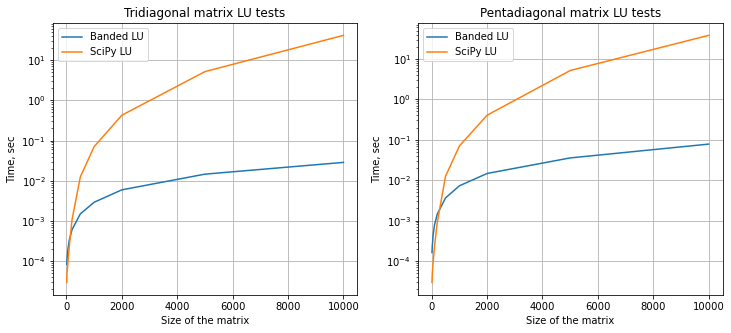

In [126]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(sizes, band_3, label="Banded LU")
axs[0].plot(sizes, sc_lu_3, label="SciPy LU")
axs[0].set_title("Tridiagonal matrix LU tests")

axs[1].plot(sizes, band_5, label="Banded LU")
axs[1].plot(sizes, sc_lu_5, label="SciPy LU")
axs[1].set_title("Pentadiagonal matrix LU tests")

for item in axs:
    item.set_yscale('log')
    item.grid()
    item.legend()
    item.set_xlabel("Size of the matrix")
    item.set_ylabel("Time, sec")

Utilizing the special form of the matrix allows us to reduce the computational complexity of the LU decomposition

### 2. Stability of LU (8 pts)

* (4 pts) Show, that for these  matrices $A$ and $B$ LU decomposition fails. Why does it happen?



$
A = \begin{pmatrix}
0 & 1 \\
2 & 3
\end{pmatrix}.$ 

$B = \begin{pmatrix}
1 & 1 & 0\\
1 & 1 & 2 \\
1 & 2 & 1
\end{pmatrix}.$ 

* (4 pts) In the LU decomposition, a pivot position is a position of the element that identifies the row and column that will be eliminated in the current step. For example, first pivot in LU is usually the left top element. What value of $c$ leads to zero in the second pivot position? What $c$ produces zero in the third pivot position? What modification of LU should we use in order to address the possible zeros in pivot position?

$A = \begin{pmatrix}
1 & c & 0\\
2 & 4 & 1 \\
3 & 5 & 1
\end{pmatrix}.$ 

_1._

In lecture 5 it was stated that that for strictly regular matrices (i.e. ones that have non-singular leading principal minors) LU always exists. 
For $A$ we have $\delta_1 = 0, \ \delta_2 = \det{A}$, so the very first principal minor is singular. Thus, we can't decompose $A$ into $LU$ without permutations.

For $B$ we have $\delta_1 = 1, \ \delta_2 = \det{\begin{pmatrix} 
1 & 1\\
1 & 1
\end{pmatrix}} = 0$, so second principal minor is singular and LU decomposition fails.

_2._
Let's make the first step of Gaussian elimination
$$
\begin{pmatrix}
1 & с & 0 \\
2 & 4 & 1\\
3 & 5 & 1
\end{pmatrix} \rightarrow
\begin{pmatrix}
1 & с & 0 \\
0 & 4-2c & 1\\
0 & 5-3c & 1
\end{pmatrix}
$$
So $c=2$ will produce $0$ in the $(2,2)$ position, that should've been second pivot, whereas $c=5/3$ would've eliminate the $(3,2)$ position. If $c=1$ then we see that $4-2c=5-3c$ and after elimination of the third row we would get the row of all zeros. 

To prevent all this from happening we can use permutation, so each new pivoting position will contain non-zero element.

### 3. Implementation of PLU decomposition (14 pts)

As you have noticed before, LU decomposition may fail. In order to make it stable, we can use LU decomposition with pivoting  (PLU).

We want to find such permutation matrix $P$ that LU decomposition of $PA$ exists

$$ PA = LU $$

- (7 pts) Implement efficiently PLU decomposition (without loops and with appropriate level of BLAS operations).  Also, pay attention to the way of permutation matrix storage.

- (4 pts ) Compare your function for computing PLU with built-in function on matrices of such type ```(mirror_diag = [1,2,1], n = 4)```. (Bandwidth and matrix size may vary). So, you can pass them as dense 2D NumPy array and do not tune your implementation to this special structure. Compare them in terms of running time (use ```%timeit``` magic) for range of dimensions to recover the asymptotic rate of time increasing and in terms of acuracy. We expect you plot the running time vs matrix dimension for built-in function and your implementation. So you should get the plot with two lines.
Consider additionally one of the pathological examples from above, where LU fails, but PLU has to work.


$$A = \begin{pmatrix}
0 & 0 & 1 & 1 \\
 0 &1 & 2 & 1  \\
 1 & 2 & 1  & 0\\
1 & 2  & 0 & 0  \\
\end{pmatrix}.$$


- (3 pts) Discuss the obtained results and explain how is it possible to accelerate computing the PLU factorization. 

NumPy or JAX are both ok in this problem, but please use the single library for all implementations. 

In [24]:
def plu_dec(A):
    """
        PLU decomposition
        input: matrix A of size n x n
        output: array piv, its entries are permuted as the rows of matrix P (originally identity matrix, after permutations 
                of columns becomes the desired permutation matrix for decomposition), s.t. A=PLU
                P = P[piv]
                matrix A, its upper triangle part is U, below main diagonal are entries of L,
                so U = upper(A)
                L = lower(A) - diag(A) + identity
    """
    n = A.shape[0]
    piv = np.arange(0, n)
    for k in np.arange(n-1):
        #find pivoting index
        max_ind = np.argmax(np.abs(A[k:n, k])) + k
        #perform pivot
        piv[[k, max_ind]] = piv[[max_ind, k]]
        A[[k, max_ind]] = A[[max_ind, k]]
        #compute decomposition
        A[k+1:, k] = A[k+1:, k] / A[k ,k]
        A[k+1:, k+1:] -= np.outer(A[k+1:, k],A[k, k+1:])
        
    return piv, A      

In [25]:
#small test of correctness of our PLU
from scipy.linalg import lu

A = np.array([[3., 2., 1., -10.],
              [2., -5., 9., 4.],
              [4., -4., 5., 3],
              [5., -5., 8., 9.]])


Ps, Ls, Us = lu(A)
P, A = plu_dec(A)
U = np.triu(A)
L = np.eye(4) + np.tril(A, -1)
print(np.linalg.norm(Ls @ Us - L @ U))

1.0877919644084146e-15


In [40]:
size = 6
diag_broadcast = [1, 2, 1]
A = diags(diag_broadcast, [-1, 0, 1], shape=(size, size)).toarray()
mirror_A = np.rot90(A)
print("Mirrored matrix mirror_A\n", mirror_A)

perm, A_dec = plu_dec(mirror_A.copy())
P = np.eye(size)
L = np.eye(size) + np.tril(A_dec, -1)
U = np.triu(A_dec)
print("Norm of difference mirror_A - PLU\n", np.linalg.norm(mirror_A - P[perm] @ L @ U))

Mirrored matrix mirror_A
 [[0. 0. 0. 0. 1. 2.]
 [0. 0. 0. 1. 2. 1.]
 [0. 0. 1. 2. 1. 0.]
 [0. 1. 2. 1. 0. 0.]
 [1. 2. 1. 0. 0. 0.]
 [2. 1. 0. 0. 0. 0.]]
Norm of difference mirror_A - PLU
 0.0


In [42]:
diag3 = [-1, 2, -1]
diag5 = [1, 2, 5, 2, 1]

band_3 = []
band_5 = []

sc_lu_3 = []
sc_lu_5 = []

sizes = np.array([10, 20, 50, 100, 200, 500, 1000])
for item in sizes:
    A = diags(diag3, [-1, 0, 1], shape=(item, item)).toarray()
    A = np.rot90(A)
    band = %timeit -oq plu_dec(A)
    band_3.append(band.best)
    sc_lu = %timeit -oq lu(A)
    sc_lu_3.append(sc_lu.best)
    
    A = diags(diag5, [-2, -1, 0, 1, 2], shape=(item, item)).toarray()
    A = np.rot90(A)
    band = %timeit -oq plu_dec(A)
    band_5.append(band.best)
    sc_lu = %timeit -oq lu(A)
    sc_lu_5.append(sc_lu.best)

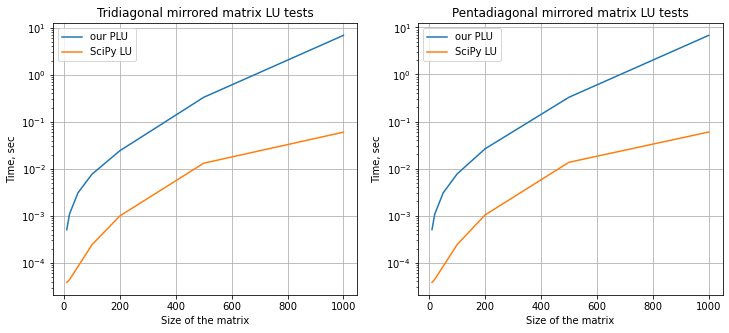

In [43]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(sizes, band_3, label="our PLU")
axs[0].plot(sizes, sc_lu_3, label="SciPy LU")
axs[0].set_title("Tridiagonal mirrored matrix LU tests")

axs[1].plot(sizes, band_5, label="our PLU")
axs[1].plot(sizes, sc_lu_5, label="SciPy LU")
axs[1].set_title("Pentadiagonal mirrored matrix LU tests")

for item in axs:
    item.set_yscale('log')
    item.grid()
    item.legend()
    item.set_xlabel("Size of the matrix")
    item.set_ylabel("Time, sec")

Unfortunately, our PLU implementation is more computationally expensive then the one from scipy. Can't say I'm surprised, because scipy uses an optimized algorithm from LAPACK

### 4. Block LU (10 pts)

Let $A = \begin{bmatrix} A_{11} & A_{12} \\ A_{21} & A_{22} \end{bmatrix}$ be a block matrix. The goal is to solve the linear system

$$
     \begin{bmatrix} A_{11} & A_{12} \\ A_{21} & A_{22} \end{bmatrix} \begin{bmatrix} u_1 \\ u_2 \end{bmatrix} = \begin{bmatrix} f_1 \\ f_2 \end{bmatrix}.
$$

* (2 pts) Using block elimination find matrix $S$ and right-hand side $\hat{f_2}$ so that $u_2$ can be found from $S u_2 = \hat{f_2}$. Note that the matrix $S$ is called <span style="color:red">Schur complement</span> of the block $A_{11}$.
* (4 pts) Using Schur complement properties prove that 

$$\det(X+AB) = \det(X)\det(I+BX^{-1}A), $$


where $X$ - nonsingular square matrix.
* (4 pts) Let matrix $F \in \mathbb{R}^{m \times n}$ and $G \in \mathbb{R}^{n \times m}$. Prove that 

$$\det(I_m - FG) = \det(I_n - GF).$$

_1._

Let's make the block LU for $A$ (assuming that $A_{11}$ is invertible):
$$
\begin{bmatrix}
A_{11} & A_{12}\\
A_{21} & A_{22}
\end{bmatrix} \rightarrow \begin{bmatrix}
A_{11} & A_{12}\\
0 & A_{22} - A_{21} A_{11}^{-1} A_{12}
\end{bmatrix} = U \rightarrow
A = LU, L=\begin{bmatrix}
I & 0 \\
A_{21} A_{11}^{-1} & I
\end{bmatrix}
$$
Then for $\hat{f}$:
$$
\hat{f} = L f = \begin{bmatrix}
I & 0 \\
A_{21} A_{11}^{-1} & I
\end{bmatrix} \begin{bmatrix}
f_1\\
f_2
\end{bmatrix} = \begin{bmatrix}
f_1\\
A_{21}A_{11}^{-1}f_1 + f_2
\end{bmatrix}
$$
So for $Su_2=\hat{f}_2$:
$$
\left(A_{22} - A_{21}A_{11}^{-1}A_{12}\right) u_2 = A_{21}A_{11}^{-1}f_1 + f_2
$$

_2._

Let's write a block matrix to represent this determinant. Clearly $\det{\left(X+AB\right)} = \det \begin{bmatrix}
I & -A\\
B & X
\end{bmatrix}$
Using Gaussian elimination on the right with block L matrix as $L = \begin{bmatrix}
I & 0\\
BX^{-1} & I
\end{bmatrix}$ 
We can get $$ D = 
\begin{bmatrix}
I & -A\\
B & X
\end{bmatrix} = \begin{bmatrix}
I+BX^{-1}A & -A\\
0 & X
\end{bmatrix} 
\begin{bmatrix}
I & 0\\
BX^{-1} & I
\end{bmatrix}  = \hat{D} L
$$

Clearly $\det{D} = \det{\left(\hat{D}L\right)} = \det{\hat{D}} \det{L} = \det{\hat{D}}$, so
$\det{D} = \det{\left(X+AB\right)} = \det{\hat{D}} = \det{\left(\left(I + BX^{-1}A\right)X\right)} = \det{X} \det{\left(I + BX^{-1}A\right)}$

_3._

The required equality is a direct consequence of the previous exercise. Let's use the fololowing rule: we can perform kind of matrix multiplication of two identity matrices of different shapes by stretching or squeezing of the matrices: $I_m I_n = \begin{cases}
I_m,\\
I_n
\end{cases}$

Then $\det{\left(I_m - FG\right)} = \det \begin{bmatrix}
I_m & F\\
G & I_n
\end{bmatrix}$


As in previous exercies we will use Schur complement: for $I_n$ and for $I_m$. Recall that the inverse of identity is identity.

$$
\det{\left(I_m - FG\right)} = \det{\left(I_n \left(I_m - FG\right)\right)} = \det \begin{bmatrix}
I_m - FG & F\\
0 & I_n
\end{bmatrix} = 
\det \begin{bmatrix}
I_m & F\\
G & I_n
\end{bmatrix} = \det \begin{bmatrix}
I_m & F\\
0 & I_n - GF
\end{bmatrix} = \det I_m \det{\left(I_n - GF\right)} = \det{\left(I_n - GF\right)}
$$

## Problem 2 (eigenvalues)  (50 pts)

### 1. Theoretical tasks (15 pts)

* (2 pts) Prove that eigenvectors that correspond to distinct eigenvalues are linearly independent.

* (3 pts) $A$ is a matrix such that $a_{i,j} \ge 0$ and $\sum_{j}a_{i,j} = 1$ (sum of the elements in each row is 1). Prove that $A$ has an eigenvalue $\lambda=1$ and that any eigenvalue $\lambda_i$: $|\lambda_i| \le 1$.

* (5 pts) Prove that normal matrix is Hermitian iff its eigenvalues are real. Prove that normal matrix is unitary iff its eigenvalues satisfy $|\lambda| = 1$. 

* (5 pts) The following problem illustrates instability of the Jordan form. Find theoretically the eigenvalues of the perturbed Jordan block (there is only one $\varepsilon$ - in the left lower corner):

$$
    J(\varepsilon) = 
    \begin{bmatrix} 
     \lambda & 1 & & & 0 \\ 
     0 & \lambda & 1 & & \\ 
     & 0 & \ddots & \ddots & \\ 
     & & 0 & \lambda & 1 \\ 
     \varepsilon & & & 0 & \lambda  \\ 
    \end{bmatrix}_{n\times n}
$$

   Comment how eigenvalues of $J(0)$ are perturbed for large $n$.

## 1

_1._
Let's prove this by induction. We consider a linear map $A$ with set of distinct eigenvalues $\lambda_1,\ldots,\lambda_n$ and corresponding eigenvectors $x_1,\ldots,x_n$.

For $k=1$ the statement is trivial. Let's assume that it's true for $k-1$, so $x_1,\ldots,x_{k-1}$ are linearly independent. Consider such a linear combination for $k$ and let's say $x_1,\ldots,x_k$ are linearly dependent:

$$
\sum\limits_{i=1}^n \alpha_i x_i = 0, \ \exists \alpha_i \ne 0, \ i \in \overline{1, k}\\
A \sum\limits_{i=1}^n \alpha_i x_i = \sum\limits_{i=1}^n \alpha_i Ax_i = \sum\limits_{i=1}^n \alpha_i \lambda_i x_i = 0\\
\sum\limits_{i=1}^n \alpha_i \lambda_i x_i - \lambda_k \sum\limits_{i=1}^n \alpha_i x_i = \sum\limits_{i=1}^{k-1} \alpha_i (\lambda_i - \lambda_k) x_i = 0
$$
As all eigenvalues are distinct, then $\forall i \in \overline{1, k-1} \ \lambda_i \ne \lambda_k$, so there is at least one non-zero factor in the sum. That means that $x_1,\ldots, x_{k-1}$ are linearly dependent, but it's a contradiction with the assumption of induction. Thus, set of vectors $x_1,\ldots,x_k$ is linearly independent.


_2._ 
Let's take a vector of ones: $\mathbb{1}$ and multiply it with $A$:
$$
A \mathbb{1} = \begin{pmatrix}
\sum_j a_{1j}\\
\vdots\\
\sum_j a_{nj}
\end{pmatrix} = \mathbb{1}
$$
Thus, $\mathbb{1}$ is an eigenvector of $A$ with eigenvalue 1. Now, let's consider an arbitrary eigenvector $v$ of $A$:
$$
Av = \lambda v\\
\sum_{j=1}^n a_{ij} v_j = \lambda v_i
$$
Let $|v_k| = max\{|v_1|,\ldots,|v_n|\}$. $|v_k| > 0$, otherwise it wouldn't have been ai eigenvector (zero vector can't be an eigenvector). Then
$$
|\lambda| |v_k| \leq |\sum_{j=1}^n a_{kj} v_j| \leq \sum_{j=1}^n |a_{kj}| |v_j| \leq \sum_{j=1}^n |a_{kj}| |v_k| = \sum_{j=1}^n a_{kj}|v_k| = |v_k|
$$
Thus, $|\lambda| \leq 1$


_3._

By the theorem of decomposition of  a normal matrix, for normal $A$ $\exists U, \Lambda$, $U$ - unitary, $\Lambda$ - diagonal matrix, $A = U \Lambda U^*$.
Let's prove that if eigenvalues of normal $A$ are real, then $A$ is Hermitian. In this case $\Lambda$ is real-valued diagonal matrix and $\Lambda^* = \Lambda$. Thus, $A^* = (U \Lambda U^*)^* = U \Lambda U^*$, so $A$ is Hermitian.

Now we consider Hermitian $A$, then $A^* = A$. Then considering an eigenvector $x$: 
$$
(Ax, x) = (x, A^* x) = (x, \lambda^* x) = \lambda(x,x) = \lambda^*(x,x)\\
(\lambda - \lambda^*) (x,x) = 0 \rightarrow \lambda = \lambda^*
$$
So all eigenvalues are real.

Now let's consider unitary normal matrix $A$, then $A^* A = AA^* = I$. Let $\lambda$ be an eigenvalue with eigenvector $x$:
$
Ax = \lambda x
$, then also $(Ax)^* = x^* A^* = \lambda^* x^*$. Let's perform dot product
$$
x^* A^* A x = x^* I x = \|x\|^2 = \lambda^* \lambda x^* x = |\lambda|^2 \|x\|^2
$$
That means, that $|\lambda| = 1$.

Now, for normal matrices $A^* A = A A^*$ i.e. they commute $[A^*, A] = 0$. Then for eigenvector $x$
$$
A^* A x = A^* \lambda x = AA^* x = A \lambda^* x = |\lambda|^2 x = x
$$
That means $AA^* = I$, so $A$ is unitary.

_4._

From the form ob Jordan block it's obvious that there is an eigenvalue $\lambda$ with algebraic multiplicity $n$ for $J(0)$.

Building the characteristic polynomial will lead to the equation of the form (just expand the determinant via the lowest row)
$$
(-1)^{1+n} \varepsilon + (\lambda - \hat{\lambda})^n = 0
$$
Where $\hat{\lambda}$  are the eigenvalues. 
For even $n$: 
$$
(\lambda - \hat{\lambda})^n = \varepsilon\\
\hat{\lambda} = \lambda \pm \varepsilon^{1/n}
$$
For odd $n$:
$$
\hat{\lambda} = \lambda + \varepsilon^{1/n}
$$
So in both cases as $n \to \infty: \ \hat{\lambda} \to \lambda$, but in the even case instaed of one eigenvalue we will get 2 eigenvalues. 

### 2. PageRank (35 pts)


#### Damping factor importance

* (5 pts) Write the function ```pagerank_matrix(G)``` that takes an adjacency matrix $G$ (in both sparse and dense formats) as an input and outputs the corresponding PageRank matrix $A$.

In [26]:
import scipy.sparse as spsp

In [30]:
# INPUT:  G - np.ndarray or sparse matrix
# OUTPUT: A - np.ndarray (of size G.shape) or sparse matrix
def pagerank_matrix(G):
    """
        pagerank matrix construction
        input: adjacency matrix G of the given graph (either in sparse format, supported by scipy, or dense as np.ndarray)
        output: pagerank matrix of the same type as input 
    """
    if spsp.issparse(G):
        factors = G.sum(axis=0)
        factors = np.where(factors==0, 1, factors)
        diag = spsp.diags(np.squeeze(1 / factors))
        return G @ diag
    elif isinstance(G, np.ndarray):
        A = G / G.sum(axis=0)
        return A
    else:
        raise NotImplementedError()

* (3 pts) Find PageRank matrix $A$ that corresponds to the following graph: <img src="graph.png" width='250'>
What is its largest eigenvalue? What multiplicity does it have?


* (5 pts) Implement the power method for a given matrix $A$, an initial guess $x_0$ and a number of iterations ```num_iter```. It should be organized as a function ```power_method(A, x0, num_iter)``` that outputs approximation to eigenvector $x$, eigenvalue $\lambda$ and history of residuals $\{\|Ax_k - \lambda_k x_k\|_2\}$. Make sure that the method converges to the correct solution on a matrix $\begin{bmatrix} 2 & -1 \\ -1 & 2 \end{bmatrix}$ which is known to have the largest eigenvalue equal to $3$.

Adjacency matrix $G$ of the graph is 
$$
\begin{pmatrix}
0 & 1 & 0 & 0 & 0\\
0 & 0 & 1 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 1\\
0 & 0 & 0 & 1 & 0
\end{pmatrix}
$$
Corrseponding normalized left-stochastic matrix has a maximum eigenvalue of $1$.

In [234]:
G = np.zeros((5,5))
G[0, 1] = 1
G[1, 2] = 1
G[2, 0] = 1
G[2, 1] = 1
G[3, 4] = 1
G[4, 3] = 1

In [235]:
#check if our implementation is correct for both dense and sparse matrices
print(G)
print("Matrix A\n",pagerank_matrix(G))
G_sp = spsp.csr_matrix(G)
print("Matrix A, from sparse format\n",pagerank_matrix(G_sp).toarray())

[[0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]]
Matrix A
 [[0.  0.5 0.  0.  0. ]
 [0.  0.  1.  0.  0. ]
 [1.  0.5 0.  0.  0. ]
 [0.  0.  0.  0.  1. ]
 [0.  0.  0.  1.  0. ]]
Matrix A, from sparse format
 [[0.  0.5 0.  0.  0. ]
 [0.  0.  1.  0.  0. ]
 [1.  0.5 0.  0.  0. ]
 [0.  0.  0.  0.  1. ]
 [0.  0.  0.  1.  0. ]]


Let's take a look at eigenvalues of this matrix

In [236]:
np.linalg.eig(pagerank_matrix(G))[0]

array([-0.5+0.5j, -0.5-0.5j,  1. +0.j ,  1. +0.j , -1. +0.j ])

We see that multiplicty of the largest eigenvalue is 2.

In [33]:
# INPUT:  A - np.ndarray (2D), x0 - np.ndarray (1D), num_iter - integer (positive)
# OUTPUT: x - np.ndarray (of size x0), l - float, res - np.ndarray (of size num_iter + 1 [include initial guess])
def power_method(A, x0, num_iter): # 5 pts
    """
        Power Iteration method
        input: matrix A of size n x n, 
               initial guess vector x0 of size n,
               number of iterations num_iter
        output: approximate eigenvector x,
                approximate eigenvalue l,
                array of residuals res
    """
    x0 = x0 / np.sqrt(np.sum(np.power(x0, 2)))
    res = np.empty(num_iter+1)
    res[0] = np.sqrt(np.sum(np.power(A @ x0 - (x0 @ (A @ x0)) * x0 , 2)))
    for i in range(num_iter):
        x0 = A @ x0
        x0 = x0 / np.sqrt(np.sum(np.power(x0, 2)))
        l = x0 @ (A @ x0)
        res[i+1] = np.sqrt(np.sum(np.power(A @ x0 - l * x0, 2)))
    return x0, l, res

In [35]:
A = np.array([[2, -1],
              [-1, 2]])
xmax, lmax, res = power_method(A, np.array([0, 1]), 10)
print("Eigenvector of maximum eigenvalue:", res)
print("Max eigenvalues (must be almost 3):", lmax)

Eigenvector of maximum eigenvalue: [1.00000000e+00 6.00000000e-01 2.19512195e-01 7.39726027e-02
 2.46875952e-02 8.23031329e-03 2.74347906e-03 9.14494550e-04
 3.04831573e-04 1.01610527e-04 3.38701756e-05]
Max eigenvalues (must be almost 3): 2.999999999426406


Let's make the two tasks below here, because the its Markdown cell is way to big to scroll from its top to solutions below it

0.5082555215453148


Text(0, 0.5, 'Value of residual')

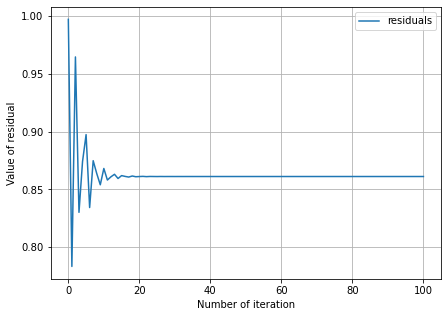

In [39]:
x0 = np.random.randn(G.shape[0])
xmax, lmax, res = power_method(pagerank_matrix(G), x0, 100)
print(lmax)

fig, axs = plt.subplots(1, 1, figsize=(7, 5))
axs.plot(np.arange(101), res, label="residuals")
axs.legend()
axs.grid()
axs.set_xlabel("Number of iteration")
axs.set_ylabel("Value of residual")

In addition to eigenvalue $1$ we also have eigenvalue $-1$, they have two distinct corresponding eigenvectors. The resulting vector at each step will be spanned by these two vectors and we won't converge to the max eigenvalue (we will oscillate between $-1$ and $1$)

In [237]:
#new G matrix with loop on vertex 4
G[4, 4] = 1
print(G)
print(np.linalg.eig(pagerank_matrix(G))[0])

[[0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 1.]]
[-0.5+0.5j -0.5-0.5j  1. +0.j  -0.5+0.j   1. +0.j ]


Now, this new matrix $A$ doesn't have the issue of the previous one. Thus, we expect to observe convergence (eigenvalue $1$ still has the multiplicity of 2, but there is no problem with that))

In [217]:
x0s = np.empty((10, G.shape[0]))
eigs = np.empty((10, G.shape[0]))
lmaxs = np.empty(10)
x0s[0] = np.random.randn(G.shape[0])
x0s[1] = np.ones(G.shape[0])
x0s[2] = np.array([1, 0, 0, 0, 0])
x0s[3] = 2 * np.random.rand(G.shape[0]) - 1
x0s[4] = np.random.randn(G.shape[0]) * np.random.rand() + np.random.rand()
x0s[5] = np.random.randn(G.shape[0]) * 2 + 1
x0s[6] = np.random.randn(G.shape[0])
x0s[7] = np.random.rand(G.shape[0])
x0s[8] = np.array([0, 0, 0, 0, 1])
x0s[9] = np.array([1, -1, -1, 1, -1])
for i, it in enumerate(x0s):
    xmax, lmax, res = power_method(pagerank_matrix(G), it, 100)
    eigs[i] = xmax
    lmaxs[i] = lmax

In [218]:
print("Eigenvalues:",lmaxs)
print("Eigenvectors")
print(eigs)

Eigenvalues: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Eigenvectors
[[ 3.20639873e-01  6.41279747e-01  6.41279747e-01  1.22238000e-01
   2.44476001e-01]
 [ 2.56724057e-01  5.13448115e-01  5.13448115e-01  2.85248953e-01
   5.70497905e-01]
 [ 3.33333333e-01  6.66666667e-01  6.66666667e-01  0.00000000e+00
   0.00000000e+00]
 [-2.67482361e-01 -5.34964723e-01 -5.34964723e-01  2.66862765e-01
   5.33725530e-01]
 [ 2.99689431e-01  5.99378861e-01  5.99378861e-01  1.95793875e-01
   3.91587749e-01]
 [ 2.66792930e-01  5.33585859e-01  5.33585859e-01  2.68102142e-01
   5.36204285e-01]
 [-2.69483021e-01 -5.38966042e-01 -5.38966042e-01 -2.63214784e-01
  -5.26429569e-01]
 [ 1.65764316e-01  3.31528632e-01  3.31528632e-01  3.87994774e-01
   7.75989548e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  4.47213595e-01
   8.94427191e-01]
 [-3.33333333e-01 -6.66666667e-01 -6.66666667e-01  1.31476818e-30
  -1.31476818e-30]]


Apparently the choice of initial guess affects the eigenvector we converge to. As the multiplicity of eigenvalue $1$ equals two, we have a subspace spanned by two vectors, so the resulting appoximation of eigenvector lies somewhere on the spanned plane. But this plane is a subspace of eigenvalue $1$.

* (2 pts) Run the power method for the graph presented above and plot residuals $\|Ax_k - \lambda_k x_k\|_2$ as a function of $k$ for ```num_iter=100``` and random initial guess ```x0```.  Explain the absence of convergence. 


* (2 pts) Consider the same graph, but with additional self loop at node 4 (self loop is an edge that connects a vertex with itself). Plot residuals as in the previous task and discuss the convergence. Now, run the power method with ```num_iter=100``` for 10 different initial guesses and print/plot the resulting approximated eigenvectors. Why do they depend on the initial guess?


In order to avoid this problem Larry Page and Sergey Brin [proposed](http://ilpubs.stanford.edu:8090/422/1/1999-66.pdf) to use the following regularization technique:

$$
A_d = dA + \frac{1-d}{N} \begin{pmatrix} 1 & \dots & 1 \\ \vdots & & \vdots \\ 1 & \dots & 1 \end{pmatrix},
$$

where $d$ is a small parameter in $[0,1]$ (typically $d=0.85$), which is called **damping factor**, $A$ is of size $N\times N$. Now $A_d$ is the matrix with multiplicity of the largest eigenvalue equal to 1. 
Recall that computing the eigenvector of the PageRank matrix, which corresponds to the largest eigenvalue, has the following interpretation. Consider a person who stays in a random node of a graph (i.e. opens a random web page); at each step s/he follows one of the outcoming edges uniformly at random (i.e. opens one of the links). So the person randomly walks through the graph and the eigenvector we are looking for is exactly his/her stationary distribution â€” for each node it tells you the probability of visiting this particular node. Therefore, if the person has started from a part of the graph which is not connected with the other part, he will never get there.  In the regularized model, the person at each step follows one of the outcoming links with probability $d$ OR teleports to a random node from the whole graph with probability $(1-d)$.

* (2 pts) Now, run the power method with $A_d$ and plot residuals $\|A_d x_k - \lambda_k x_k\|_2$ as a function of $k$ for $d=0.97$, ```num_iter=100``` and a random initial guess ```x0```.

* (5 pts) Find the second largest in the absolute value eigenvalue of the obtained matrix $A_d$. How and why is it connected to the damping factor $d$? What is the convergence rate of the PageRank algorithm when using damping factor?

Usually, graphs that arise in various areas are sparse (social, web, road networks, etc.) and, thus, computation of a matrix-vector product for corresponding PageRank matrix $A$ is much cheaper than $\mathcal{O}(N^2)$. However, if $A_d$ is calculated directly, it becomes dense and, therefore, $\mathcal{O}(N^2)$ cost grows prohibitively large for  big $N$.


* (2 pts) Implement fast matrix-vector product for $A_d$ as a function ```pagerank_matvec(A, d, x)```, which takes a PageRank matrix $A$ (in sparse format, e.g., ```csr_matrix```), damping factor $d$ and a vector $x$ as an input and returns $A_dx$ as an output. 

* (1 pts) Generate a random adjacency matrix of size $10000 \times 10000$ with only 100 non-zero elements and compare ```pagerank_matvec``` performance with direct evaluation of $A_dx$.

Here we will make the $A_d$ part of the task

In [41]:
def make_ad(A, d=0.85):
    add = np.ones((A.shape)) * (1 - d) / A.shape[0]
    return d * A + add

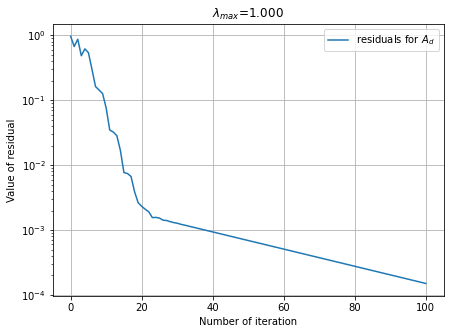

In [43]:
Ad = make_ad(pagerank_matrix(G), d=0.97)
x0 = np.random.randn(Ad.shape[0])
xmax, lmax, res = power_method(Ad, x0, 100)

fig, axs = plt.subplots(1, 1, figsize=(7, 5))
axs.plot(np.arange(101), res, label="residuals for $A_d$")
axs.set_title("$\lambda_{}$={:.3f}".format("{max}", lmax))
axs.legend()
axs.grid()
axs.set_xlabel("Number of iteration")
axs.set_ylabel("Value of residual")
axs.set_yscale("log")

How to find the second largest eigenvalue of $A_d$ with power iterations?
First, eigenvalues let's expand $A$ in terms of its eigenvalues $\lambda_i$ and eigenvectors $v_i$
$$
A = \sum\limits_{i=1}^n \lambda_i v_i v_i^T
$$
Finding the largest $\lambda_1$ and its $v_1$ we can construct $B = A - \lambda_1 v_1 v_1^T$, so eigenvalues of $B$ will be $0, \lambda_2,\ldots,\lambda_n$. Applying power iterations to $B$ we will get the second largest eigenvalue

In [212]:
xmax, lmax, res = power_method(Ad, x0, 100)
B = Ad - lmax * np.outer(xmax, xmax)
xmax2, lmax2, res2 = power_method(B, x0, 100)
print(lmax, lmax2)

1.0000013063380286 0.9699986532579493


Now the largest eigenvalue indeed is almost $1$, while the second largest is the same as $d$ parameter. When using damping we construct additional matrix of ones (which is in fact a projector onto invarint subspace of $\lambda_1$, this projector is formed as an outer product of normalized eigenvector $v_1$ on itself, which is all ones), it has only one eigenvalue $1$ and eigenvector $v_1$. 

With parameter $d$ we decrease the magnitude of all eigenvalues of $A_d$, but by adding the additional matrix (the projector of $\lambda_1 = 1$) we kind of fix the largest eigenvalue $1$ connected to eigenvector $v_1$. Thus, the second largest will be $d \cdot \lambda_2$, where $\lambda_2 = 1$ in our original matrix $A_d$.

As the convergence of the power iterations is determined by $\left|\dfrac{\lambda_2}{\lambda_1} \right|$, the introduction of the damping factor makes it $\left| d \dfrac{\lambda_2}{\lambda_1} \right|$, so it fixes the absence of convergence.

In [5]:
#well, it's stated that A must be sparse
# INPUT:  A - np.ndarray (2D), d - float (from 0.0 to 1.0), x - np.ndarray (1D, size of A.shape[0/1])
# OUTPUT: y - np.ndarray (1D, size of x)
def pagerank_matvec(A, d, x): # 2 pts
    """
        Sparse matvec multiplication
    
    """
    y = d * A.dot(x) + (1 - d) * x.sum() / len(x)
    return y

In [18]:
A_sp = spsp.random(10000, 10000, 1e-6)
x = np.random.randn(10000)

%timeit pagerank_matvec(A_sp, 0.97, x)
%timeit make_ad(A_sp.todense(), 0.97) @ x

68.3 µs ± 14 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
9.46 s ± 1.68 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


The difference between sparse matvec and dense matvec is gigantic.

#### DBLP: computer science bibliography

Download the dataset from [here](https://goo.gl/oZVxEa), unzip it and put `dblp_authors.npz`  and `dblp_graph.npz` in the same folder with this notebook. Each value (author name) from `dblp_authors.npz` corresponds to the row/column of the matrix from `dblp_graph.npz`. Value at row `i` and column `j` of the matrix from `dblp_graph.npz` corresponds to the number of times author `i` cited papers of the author `j`. Let us now find the most significant scientists according to PageRank model over DBLP data.

* (4 pts) Load the weighted adjacency matrix and the authors list into Python using ```load_dblp(...)``` function. Print its density (fraction of nonzero elements). Find top-10 most cited authors from the weighted adjacency matrix. Now, make all the weights of the adjacency matrix equal to 1 for simplicity (consider only existence of connection between authors, not its weight). Obtain the PageRank matrix $A$ from the adjacency matrix and verify that it is stochastic.
 
 
* (1 pts) In order to provide ```pagerank_matvec``` to your ```power_method``` (without rewriting it) for fast calculation of $A_dx$, you can create a ```LinearOperator```: 
```python
L = scipy.sparse.linalg.LinearOperator(A.shape, matvec=lambda x, A=A, d=d: pagerank_matvec(A, d, x))
```
Calling ```L@x``` or ```L.dot(x)``` will result in calculation of ```pagerank_matvec(A, d, x)``` and, thus, you can plug $L$ instead of the matrix $A$ in the ```power_method``` directly. **Note:** though in the previous subtask graph was very small (so you could disparage fast matvec implementation), here it is very large (but sparse), so that direct evaluation of $A_dx$ will require $\sim 10^{12}$ matrix elements to store - good luck with that (^_<).


* (2 pts) Run the power method starting from the vector of all ones and plot residuals $\|A_dx_k - \lambda_k x_k\|_2$  as a function of $k$ for $d=0.85$.


* (1 pts) Print names of the top-10 authors according to PageRank over DBLP when $d=0.85$. Comment on your findings.

In [6]:
from scipy.sparse import load_npz
import numpy as np
def load_dblp(path_auth, path_graph):
    G = load_npz(path_graph).astype(float)
    with np.load(path_auth) as data: authors = data['authors']
    return G, authors
G, authors = load_dblp('dblp_authors.npz', 'dblp_graph.npz')

In [7]:
dens = G.nnz / (G.shape[0] * G.shape[1])
print("Density of G is {:.6f}".format(dens))

Density of G is 0.000045


In [8]:
#top cited authors are
weights = np.asarray(G.sum(axis=0)).ravel()
top10 = np.argsort(weights)[-10:]
print("Top cited authors are\n",authors[top10[::-1]])

Top cited authors are
 ['Scott Shenker' 'Andrew Zisserman' 'Hari Balakrishnan' 'Jiawei Han'
 'Anil K. Jain' 'Cordelia Schmid' 'Jitendra Malik' 'Ion Stoica'
 'David E. Culler' 'David G. Lowe']


In [9]:
G.data = G.data / G.data

In [10]:
A = pagerank_matrix(G.T)

In [11]:
sums = A.sum(axis=0)
sums = sums.A1

In [12]:
zers = sums == 0
lows = sums > 0.999995
upps = sums < 1.000005
ons = lows * upps
ttl = sums[ons].shape[0] + sums[zers].shape[0]
print(A.shape[0] - ttl)

0


We know that rows/columns of right/left stochastic matrix are summing to ones. Thus, if $A$ is left stochastic matrix of size $n$, we expect to have $n$ ones as sums of its columns. 

However, it seems like due to sparcity of the matrix (or something else) we also have fully zero columns, thus we should fix the stochastisity of $A$ by the number of such columns.

In [13]:
import scipy.sparse.linalg

In [14]:
L = scipy.sparse.linalg.LinearOperator(A.shape, 
                                       matvec=lambda x, A=A, d=0.85: pagerank_matvec(A, d, x))

xmax, lmax, res = power_method(L, np.ones(A.shape[0]), 100)

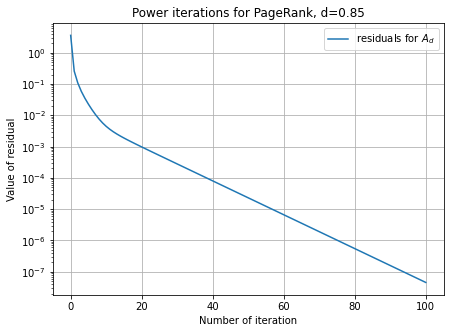

In [16]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 1, figsize=(7, 5))
axs.plot(np.arange(101), res, label="residuals for $A_d$")
axs.set_title("Power iterations for PageRank, d={:.2f}".format(0.85))
axs.legend()
axs.grid()
axs.set_xlabel("Number of iteration")
axs.set_ylabel("Value of residual")
axs.set_yscale("log")

In [17]:
lmax

0.9623494995541925

In [18]:
ind10 = np.argsort(xmax)[-10:]
print("Top 10 authors are\n",authors[ind10[::-1]])

Top 10 authors are
 ['David E. Goldberg' 'Richard M. Karp' 'John E. Hopcroft'
 'Azriel Rosenfeld' 'Ronald L. Rivest' 'Anil K. Jain' 'Takeo Kanade'
 'Alfred V. Aho' 'Robert Endre Tarjan' 'Gerard Salton']


Top-10 according to PageRank authors are kind of different from top-10 most cited authors.

## Problem 3. QR algorithm (33 pts)

* Implement QR-algorithm without shifts. Prototype of the function is given below

In [45]:
import scipy.linalg

In [271]:
# INPUT: 
# A_init - square matrix, 
# num_iter - number of iterations for QR algorithm
# OUTPUT: 
# Ak - transformed matrix A_init given by QR algorithm, 
# convergence - numpy array of shape (num_iter, ), 
# where we store the maximal number from the Chebyshev norm 
# of triangular part of the Ak for every iteration
def qr_algorithm(A_init, num_iter): # 3 pts
    """
        QR algorithm without shifts
        input: matrix A_init of size n x n to find its eigenvalues 
               num_iter number of iterations for algorithm to run 
    """
    convergence = np.empty(num_iter)
    Ak = A_init
    for i in np.arange(num_iter):
        Q, R = scipy.linalg.qr(Ak)
        Ak = R @ Q
        convergence[i] = scipy.linalg.norm(np.triu(Ak, 1), ord=np.inf)
    return Ak, convergence

#### Symmetric case (3 pts)
- Create symmetric tridiagonal $11 \times 11$ matrix with elements $-1, 2, -1$ on sub-, main- and upper diagonal respectively without using loops.
- Run $400$ iterations of the QR algorithm for this matrix.
- Plot the output matrix with function ```plt.spy(Ak, precision=1e-7)```.
- Plot convergence of QR-algorithm.

Text(0.5, 1.0, 'Scheme of nonzero elements in output of QR algorithm')

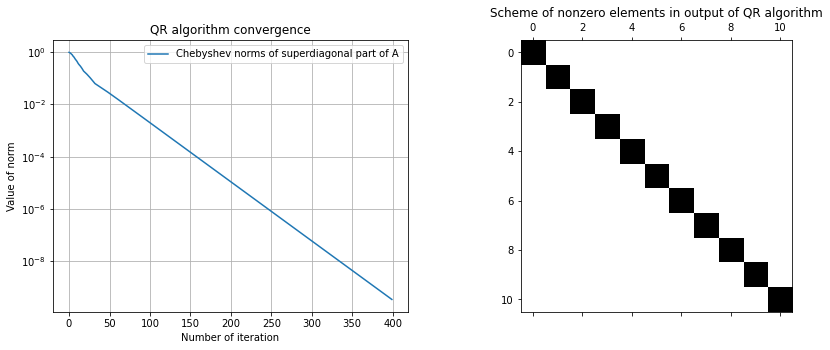

In [272]:
diag_broadcast = [-1, 2, -1]
size = 11
band_sym = scipy.sparse.diags(diag_broadcast, [-1, 0, 1], shape=(size, size)).toarray()

band_a, convergence = qr_algorithm(band_sym, 400)

fig, axs = plt.subplots(1, 2, figsize=(14, 5))
axs[0].plot(np.arange(400), convergence, label="Chebyshev norms of superdiagonal part of A")
axs[0].set_title("QR algorithm convergence")
axs[0].legend()
axs[0].grid()
axs[0].set_xlabel("Number of iteration")
axs[0].set_ylabel("Value of norm")
axs[0].set_yscale("log")

axs[1].spy(band_a, precision=1e-7)
axs[1].set_title("Scheme of nonzero elements in output of QR algorithm")

In [52]:
print(scipy.linalg.eig(band_sym)[0].real)
print(np.diag(band_a))

[3.93185165 3.73205081 3.41421356 3.         2.51763809 2.
 1.48236191 0.06814835 0.26794919 0.58578644 1.        ]
[3.93185165 3.73205081 3.41421356 3.         2.51763809 2.
 1.48236191 1.         0.58578644 0.26794919 0.06814835]


Eigenvalues of our pure QR are quite good

#### Nonsymmetric case (5 pts)

- Create nonsymmetric tridiagonal $11 \times 11$ matrix with elements $5, 3, -2$ on sub-, main- and upper diagonal respectively without using loops.
- Run $250$ iterations of the QR algorithm for this matrix.
- Plot the result matrix with function ```plt.spy(Ak, precision=1e-7)```. Is this matrix lower triangular? How does this correspond to the claim about convergence of the QR algorithm?

Text(0.5, 1.0, 'Scheme of nonzero elements in output of QR algorithm')

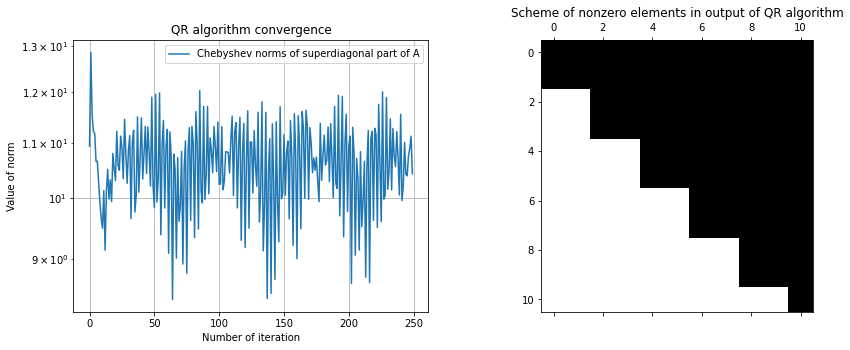

In [274]:
diag_broadcast = [5, 3, -2]
size = 11
band_nonsym = scipy.sparse.diags(diag_broadcast, [-1, 0, 1], shape=(size, size)).toarray()

band_a, convergence = qr_algorithm(band_nonsym, 250)

fig, axs = plt.subplots(1, 2, figsize=(14, 5))
axs[0].plot(np.arange(250), convergence, label="Chebyshev norms of superdiagonal part of A")
axs[0].set_title("QR algorithm convergence")
axs[0].legend()
axs[0].grid()
axs[0].set_xlabel("Number of iteration")
axs[0].set_ylabel("Value of norm")
axs[0].set_yscale("log")

axs[1].spy(band_a, precision=1e-7)
axs[1].set_title("Scheme of nonzero elements in output of QR algorithm")

The resulting matrix is upper triangular. It's well known that arbitrary matrix $A$ converges to its Schur form (i.e. upper triangular form). Here we have non-symmetric matrix, so the result is obvious.

### QR algorithms with Rayleigh Quotient shift (10 pts)

In the lectures the Rayleigh Quotient shift was introduced to speed up convergence of power method. Here we ask you to generalize this approach to construct the shifts in QR algorithm.

- How to compute the Rayleigh Quotient shift in QR algorithm fast? Provide formulas and explanations how they can be simplified.
- Implement explicit QR algorithm with Rayleigh Quotient shift. Please do not worry about implicit orthogonalization, we want to compare convergence only in terms of iterations.
- Test your implementation in the symmetric case. Plot the convergence of QR algorithm with and without shift. Choose the dimension $n \sim 100 $ for more representative results. 
- How the convergence of the shifted algorithm compares to the simple QR? Why? 

The "pure" QR algorithm in fact performs a simultaneous power iteration on each column of the matrix $A$ with appropriate orthonormalization of resulting columns of new matrix $A'$ at each new step. 

It can be shown that simultaneous iterations for identity matrix and QR algorithm are equivalent (check Lloyd, Trefethen, Bau, Numerical Linear Algebra, chapter 28)

For "pure" QR algorithm we get the sequence:
\begin{align*}
&\ A^{(0)} = A\\
&\ A^{(k-1)} = Q^{(k)}R^{(k)}\\
&\ A^{(k)} = R^{(k)} Q^{(k)}\\
&\ \underline{Q^{(k)}} = Q^{(1)}Q^{(2)}\ldots Q^{(k)}\\
&\ \underline{R^{(k)}} = R^{(k)}R^{(k-1)}\ldots R^{(1)}
\end{align*}

And by induction and equivalence with simultaneous iteration 
\begin{align*}
&\ A^k = \underline{Q^{(k)}} \ \underline{R^{(k)}}\\
&\ A^{(k)} = \underline{Q^{(k)}}^T A \underline{Q^{(k)}}
\end{align*}
So the diagonal entries of $A^{(k)}$ are Rayleigh quontients of $A$ corresponding to the columns of $\underline{Q^{(k)}}$. These columns converge to eigenvectors, thus, Rayleigh quontients converge to eigenvalues. 

It can also be proved that pure QR algorithm is equivalent to simultaneous inverse iteration, applied to matrix 
$$
P = \begin{pmatrix}
0 & 0 & \ldots & 0 & 1\\
0 & 0 & \ldots & 1 & 0\\
\vdots\\
0 & 1 & \ldots & 0 & 0\\
1 & 0 & \ldots & 0 & 0\\
\end{pmatrix}
$$

So we can utilize the idea of inverse iterations for pure QR algorithm, and the use shifts to make its convergence better. Let's denote $\mu^{(k)}$ as the shift at step $k$. The better it is as an estimation of some eigenvalue, the faster convergence will be. Then the shifted QR algorithm will be

\begin{align*}
&\ A^{(k-1)} - \mu^{(k)}I = Q^{(k)} R^{(k)}\\
&\ A^{(k)} = R^{(k)} Q^{(k)} + \mu^{(k)}I\\
&\ A^{(k)} = \underline{\left(Q^{(k)}\right)^T} A \underline{Q^{(k)}}\\
&\ (A - \mu^{(k)} I)(A - \mu^{(k-1)} I) \ldots (A- \mu^{(1)} I) = \underline{Q^{(k)}} \underline{R^{(k)}}
\end{align*}

How to choose $\mu^{(k)}$? We want to converge as fast as possible, so the last eigenvector (i.e. the last column $\underline{Q^{(k)}}$) should converge fast. Let's estimate Rayleigh quontient for it
$$
\mu^{(k)} = \dfrac{\left(q_m^{(k)}\right)^T A q_m^{(k)}}{\left(q_m^{(k)}\right)^T q_m^{(k)}} = \left(q_m^{(k)}\right)^T A q_m^{(k)} = e^T_m \underline{Q^{(k)}}^T A  \underline{Q^{(k)}} e_m = e^T_m A^{(k)} e_m = A^{(k)}_{mm}
$$
So for the shift we just take $m$-th diagonal entry of matrix $A^{(k)}$ at step $k$.

In [275]:
def qr_algorithm_reileigh(A_init, num_iter):
    """
        QR algorithm with Rayleigh shifts
        input: matrix A_init of size n x n to find its eigenvalues 
               num_iter number of iterations for algorithm to run 
    """
    convergence = np.empty(num_iter)
    Ak = scipy.linalg.hessenberg(A_init)
    for i in np.arange(num_iter):
        mu = Ak[-1, -1]
        Ak = Ak - mu * np.eye(Ak.shape[0])
        Q, R = scipy.linalg.qr(Ak)
        Ak = R @ Q + mu * np.eye(Ak.shape[0])
        convergence[i] = scipy.linalg.norm(np.triu(Ak, 1), ord=np.inf)
    return Ak, convergence

In [276]:
#test on a simple banded matrix
diag_broadcast = [-1, 2, -1]
size = 11
band_sym = scipy.sparse.diags(diag_broadcast, [-1, 0, 1], shape=(size, size)).toarray()

Text(0.5, 1.0, 'Scheme of non-zero elements after pure QR')

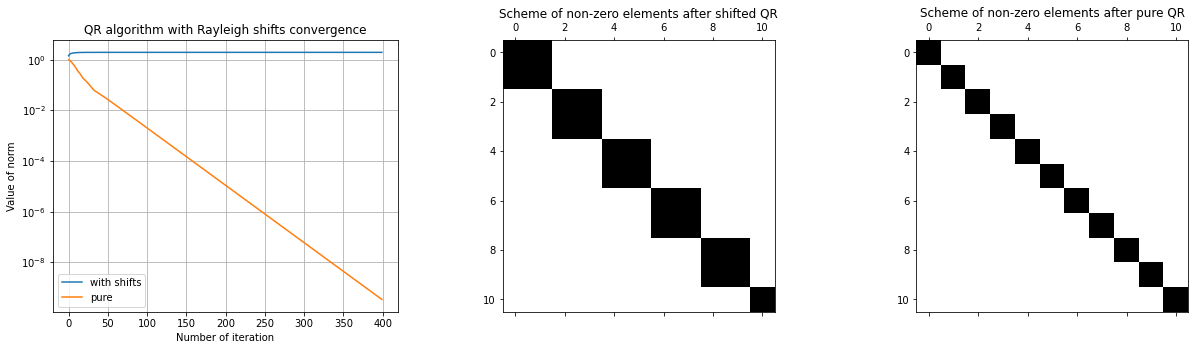

In [277]:
num_iter = 400
band_r, band_conv_r = qr_algorithm_reileigh(band_sym, num_iter)
band_pure, band_conv_pure = qr_algorithm(band_sym, num_iter)

fig, axs = plt.subplots(1, 3, figsize=(21, 5))
axs[0].plot(np.arange(num_iter), band_conv_r, label="with shifts")
axs[0].plot(np.arange(num_iter),  band_conv_pure, label="pure")
axs[0].set_title("QR algorithm with Rayleigh shifts convergence")
axs[0].legend()
axs[0].grid()
axs[0].set_xlabel("Number of iteration")
axs[0].set_ylabel("Value of norm")
axs[0].set_yscale("log")

axs[1].spy(band_r, 1e-6)
axs[1].set_title("Scheme of non-zero elements after shifted QR")
axs[2].spy(band_pure, 1e-6)
axs[2].set_title("Scheme of non-zero elements after pure QR")

In [278]:
#let's check what is on diagonals
print(np.diag(band_a))

[3.25699246 2.74300754 2.72467346 3.27532654 3.074018   2.925982
 3.80776271 2.19223729 4.15435294 1.84564706 3.        ]


We see that diagonal hasn't changed at all. Moreover, sub- and super diagonal hasn't been zeroed out - only the (n-1, n) and (n, n-1) entries are zeroes. Let's modify the choice of shifting parameter in this manner - once for (n, n) element we obtain somethinf close to zero either on (n-1, n) or (n, n-1) we choose (n-1, n-1) as shifting parameter and assign both (n-1, n) and (n, n-1) to zero (this approach is inspired by practical QR with deflation from Lloyd, Bau, Trefethen "Numerical Linear Algebra"). 

It would be also a good idea to reduce the input matrix to Hessenberg form before running iterations for better time perfomance.

We proceed until we come at (1,1) and then restart again from (n,n).

In [279]:
#to check correctness of our algorithm let's compare with eigenvalues from method from scipy
scp_eigs = scipy.linalg.eig(band_sym)[0].real
#scp_eigs = np.sort(np.abs(scp_eigs))
print(scp_eigs)

[3.93185165 3.73205081 3.41421356 3.         2.51763809 2.
 1.48236191 0.06814835 0.26794919 0.58578644 1.        ]


In [280]:
def qr_algorithm_reileigh_choice(A_init, num_iter, tol=1e-12):
    """
        QR algorithm with modified Rayleigh shifts
        input: matrix A_init of size n x n to find its eigenvalues 
               num_iter number of iterations for algorithm to run 
               tol is the precision for zeroing out close to diagonal entries (required to make the algorithm more practical)
        output: diagonal (if A_init was symmetric) matrix Ak with eigenvalues of A_init on diagonal
                convergence array of Chebyshev norms of superdiagonal entries
    """
    convergence = np.empty(num_iter)
    Ak = scipy.linalg.hessenberg(A_init)
    shift_ind = Ak.shape[0] - 1
    for i in np.arange(num_iter):
        mu = Ak[shift_ind, shift_ind]
        Ak = Ak - mu * np.eye(Ak.shape[0])
        Q, R = scipy.linalg.qr(Ak)
        Ak = R @ Q + mu * np.eye(Ak.shape[0])
        convergence[i] = scipy.linalg.norm(np.triu(Ak, 1), ord=np.inf)
        
        if ((Ak[shift_ind, shift_ind-1] < tol or Ak[shift_ind-1, shift_ind] < tol) and shift_ind > 0):
            Ak[shift_ind, shift_ind-1] = 0
            Ak[shift_ind-1, shift_ind] = 0
            shift_ind -= 1
        elif (shift_ind==0):
            shift_ind = Ak.shape[0] - 1
            
    return Ak, convergence

Text(0.5, 1.0, 'Scheme of non-zero elements after pure QR')

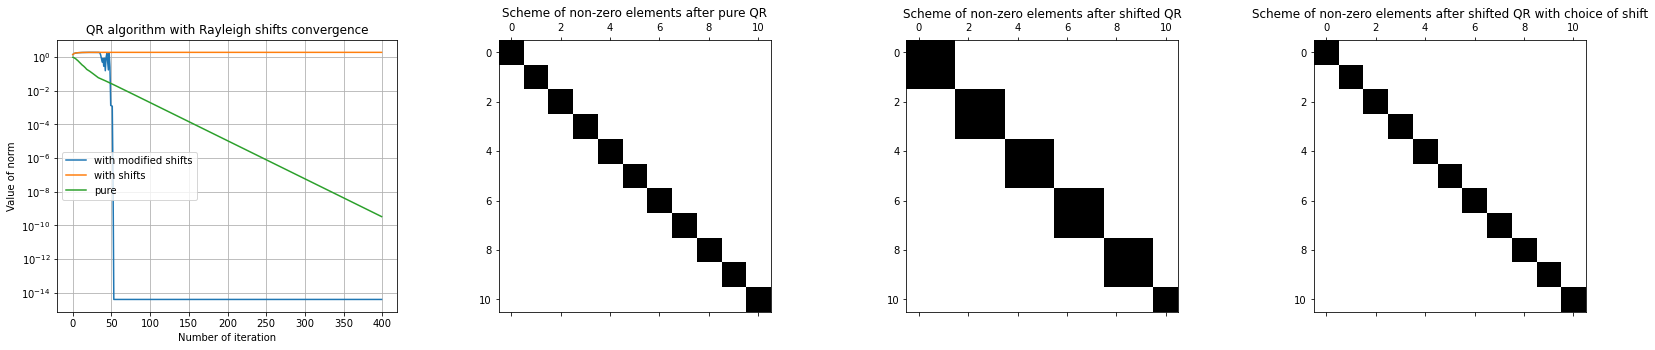

In [281]:
num_iter = 400
band_mod, band_conv_mod = qr_algorithm_reileigh_choice(band_sym, num_iter)
band_shift, band_conv_shift = qr_algorithm_reileigh(band_sym, num_iter)

fig, axs = plt.subplots(1, 4, figsize=(28, 5))
axs[0].plot(np.arange(num_iter), band_conv_mod, label="with modified shifts")
axs[0].plot(np.arange(num_iter), band_conv_shift, label="with shifts")
axs[0].plot(np.arange(num_iter), band_conv_pure, label="pure")
axs[0].set_title("QR algorithm with Rayleigh shifts convergence")
axs[0].legend()
axs[0].grid()
axs[0].set_xlabel("Number of iteration")
axs[0].set_ylabel("Value of norm")
axs[0].set_yscale("log")

axs[3].spy(band_mod, 1e-6)
axs[3].set_title("Scheme of non-zero elements after shifted QR with choice of shift")
axs[2].spy(band_shift, 1e-6)
axs[2].set_title("Scheme of non-zero elements after shifted QR")
axs[1].spy(band_pure, 1e-6)
axs[1].set_title("Scheme of non-zero elements after pure QR")

Text(0.5, 0.98, 'Errors in eigenvalues, comparison with scipy.linalg.eig')

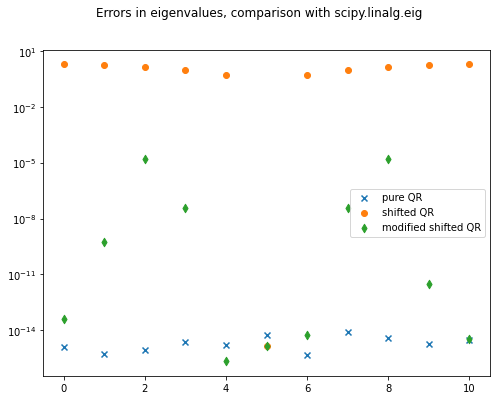

In [282]:
#here are differencies between our eigenvalues and eigenvalues obtained with scipy
scp_eigs_band = np.sort((scipy.linalg.eig(band_sym)[0].real))

fig, axs = plt.subplots(1, figsize=(8, 6))
#axs.scatter(np.arange(len(scp_eigs)), scp_eigs - , label='eigenvalues from scipy')
axs.scatter(np.arange(len(scp_eigs_band)), np.abs(scp_eigs_band - np.sort(np.diag(band_pure))), label='pure QR', marker='x')
axs.scatter(np.arange(len(scp_eigs_band)), np.abs(scp_eigs_band - np.sort(np.diag(band_shift))), label='shifted QR', marker='o')
axs.scatter(np.arange(len(scp_eigs_band)), np.abs(scp_eigs_band - np.sort(np.diag(band_mod))), label='modified shifted QR', marker='d')
axs.legend()
axs.set_yscale('log')
fig.suptitle("Errors in eigenvalues, comparison with scipy.linalg.eig")

We see that in this particular case of a specific matrix the regular Rayleigh quontient shift doesn't work at all, while modified Rayleigh shift has in general worse accuracy then pure QR. 

Let's try on a matrix of general form

Text(0.5, 1.0, 'Scheme of non-zero elements after shifted QR with choice of shift')

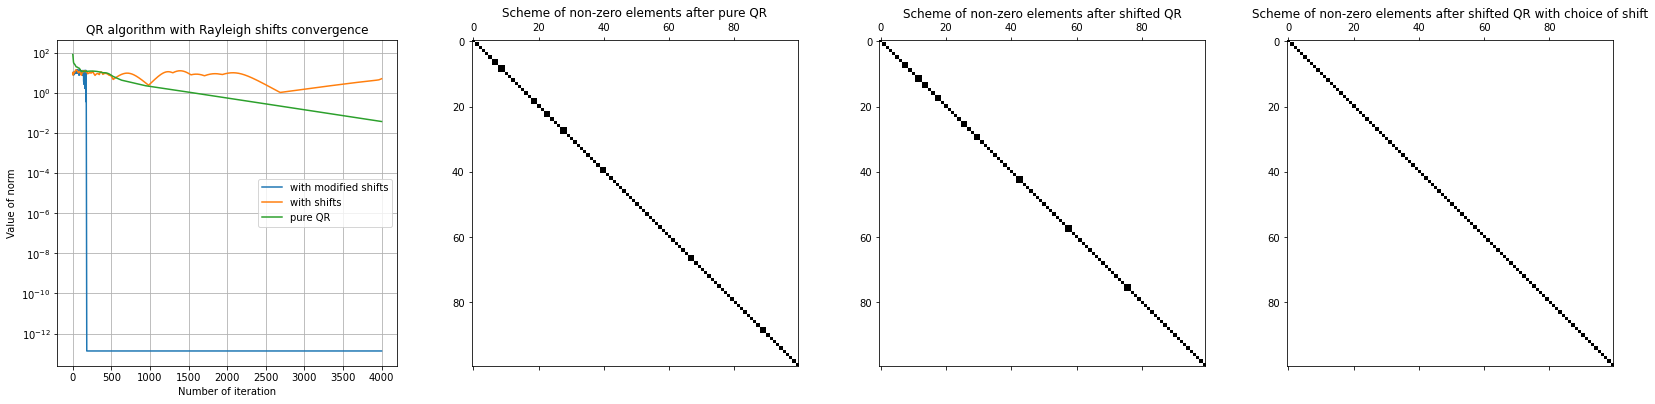

In [283]:
size = 100
A = np.random.randn(size, size)
A = (A + A.T) / 2

num_iter = 4000
a_mod, conv_mod, = qr_algorithm_reileigh_choice(A, num_iter)
a_shift, conv_shift = qr_algorithm_reileigh(A, num_iter)
a_pure, conv_pure = qr_algorithm(A, num_iter)

fig, axs = plt.subplots(1, 4, figsize=(28, 6))
axs[0].plot(np.arange(num_iter), conv_mod, label="with modified shifts")
axs[0].plot(np.arange(num_iter), conv_shift, label="with shifts")
axs[0].plot(np.arange(num_iter), conv_pure, label="pure QR")
axs[0].set_title("QR algorithm with Rayleigh shifts convergence")
axs[0].legend()
axs[0].grid()
axs[0].set_xlabel("Number of iteration")
axs[0].set_ylabel("Value of norm")
axs[0].set_yscale("log")

axs[1].spy(a_pure, 1e-6)
axs[1].set_title("Scheme of non-zero elements after pure QR")
axs[2].spy(a_shift, 1e-6)
axs[2].set_title("Scheme of non-zero elements after shifted QR")
axs[3].spy(a_mod, 1e-6)
axs[3].set_title("Scheme of non-zero elements after shifted QR with choice of shift")

Obviously as I manually assign to zero non-diagonal entries once each one of them is sufficiently close to zero the modified shifts algorithm shows better convergence, But what about actual eigenvalues? 

Text(0.5, 0.98, 'Errors in eigenvalues, comparison with scipy.linalg.eig')

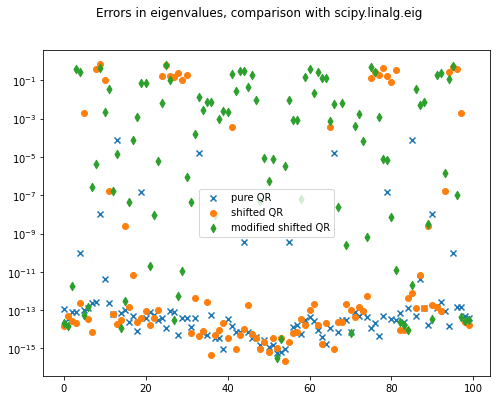

In [285]:
scp_eigs = np.sort((scipy.linalg.eig(A)[0].real))

fig, axs = plt.subplots(1, figsize=(8, 6))
#axs.scatter(np.arange(len(scp_eigs)), scp_eigs - , label='eigenvalues from scipy')
axs.scatter(np.arange(len(scp_eigs)), np.abs(scp_eigs - np.sort(np.diag(a_pure))), label='pure QR', marker='x')
axs.scatter(np.arange(len(scp_eigs)), np.abs(scp_eigs - np.sort(np.diag(a_shift))), label='shifted QR', marker='o')
axs.scatter(np.arange(len(scp_eigs)), np.abs(scp_eigs - np.sort(np.diag(a_mod))), label='modified shifted QR', marker='d')
axs.legend()
axs.set_yscale('log')
fig.suptitle("Errors in eigenvalues, comparison with scipy.linalg.eig")

Well, in this case the regular Rayleigh quontient shift yields quite good eigenvalues of original matrix, even though it doesn't reduce it to the fully diagonal form (some of the non-diagonal elements still remain present).

Modified QR (thanks to my manuall zeroing of non-diagonal entries) results in badly approximated eigenvalues. I thank the deflation straregy should be used rather than my Frankenstein version of it.

Here's another verison of shifted QR - QR with deflation (the idea is almost the same as I tried to use a couple of cells above - once we succefully found the n-th eigenvalue we start working with (n-1) x (n-1) matrix and find (n-1) eigenvalue and so forth. I had kind of a hard time trying to implement it in a suitable way, so I gave up on trying and decided to move to Wilkinson shifts)

In [286]:
def qr_algorithm_reileigh_deflate(A_init, num_iter, tol=1e-12):
    """
        QR algorithm with shifts and deflation
        input: matrix A_init of size n x n to find its eigenvalues 
               num_iter number of iterations for algorithm to run 
               tol is the precision for zeroing out close to diagonal entries (required to make the algorithm more practical)
        output: eigvals array of eigenvalues of A_init
                convergence array of ...
    """
    
    convergence = np.empty(num_iter)
    Ak = scipy.linalg.hessenberg(A_init)
    eigvals = []
    for i in np.arange(num_iter):
        mu = Ak[-1, -1]
        Ak = Ak - mu * np.eye(Ak.shape[0])
        Q, R = scipy.linalg.qr(Ak)
        Ak = R @ Q + mu * np.eye(Ak.shape[0])
        convergence[i] = scipy.linalg.norm(np.triu(Ak, 1), ord=np.inf)
        
        if (Ak.shape[0]==1):
            eigvals.append(Ak[0, 0])
            convergence[i:] = np.zeros(num_iter-i)
            return eigvals, convergence
        
        if (Ak[-2, -1] < tol or Ak[-1, -2] < tol):
            Ak[-2, -1], Ak[-1, -2] = 0., 0.
            eigvals.append(Ak[-1, -1])
            Ak = Ak[:-1, :-1]
    
    return np.array(eigvals), convergence

Let's check it on pathological example of my beloved band tridiagonal matrix

Text(0.5, 1.0, 'Errors in eigenvalues, comparison with scipy.linalg.eig')

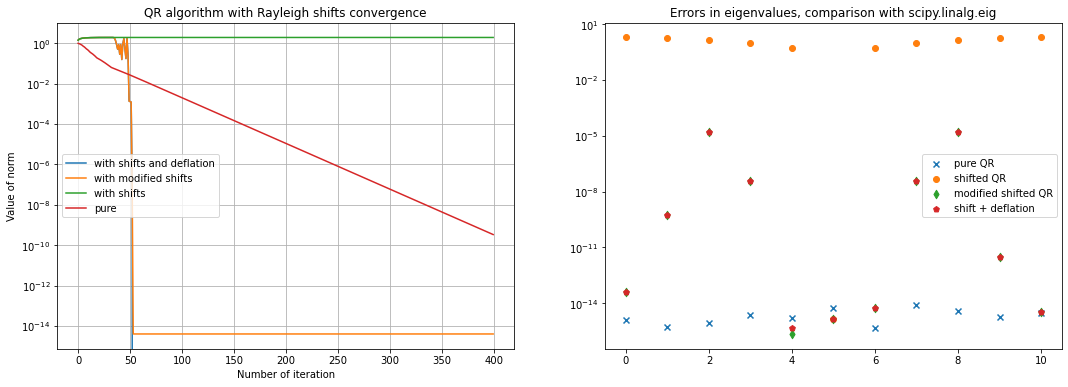

In [290]:
num_iter = 400
band_defl, band_conv_defl = qr_algorithm_reileigh_deflate(band_sym, num_iter)

fig, axs = plt.subplots(1, 2, figsize=(18, 6))
axs[0].plot(np.arange(num_iter), band_conv_defl, label="with shifts and deflation")
axs[0].plot(np.arange(num_iter), band_conv_mod, label="with modified shifts")
axs[0].plot(np.arange(num_iter), band_conv_shift, label="with shifts")
axs[0].plot(np.arange(num_iter), band_conv_pure, label="pure")
axs[0].set_title("QR algorithm with Rayleigh shifts convergence")
axs[0].legend()
axs[0].grid()
axs[0].set_xlabel("Number of iteration")
axs[0].set_ylabel("Value of norm")
axs[0].set_yscale("log")

axs[1].scatter(np.arange(len(scp_eigs_band)), np.abs(scp_eigs_band - np.sort(np.diag(band_pure))), label='pure QR', marker='x')
axs[1].scatter(np.arange(len(scp_eigs_band)), np.abs(scp_eigs_band - np.sort(np.diag(band_shift))), label='shifted QR', marker='o')
axs[1].scatter(np.arange(len(scp_eigs_band)), np.abs(scp_eigs_band - np.sort(np.diag(band_mod))), label='modified shifted QR', marker='d')
axs[1].scatter(np.arange(len(scp_eigs_band)), np.abs(scp_eigs_band - np.sort(band_defl)), label='shift + deflation', marker='p')
axs[1].legend()
axs[1].set_yscale('log')
axs[1].set_title("Errors in eigenvalues, comparison with scipy.linalg.eig")

In [291]:
num_iter = 4000
a_defl, a_conv_defl = qr_algorithm_reileigh_deflate(A, num_iter)

Text(0.5, 0.98, 'Errors in eigenvalues, comparison with scipy.linalg.eig')

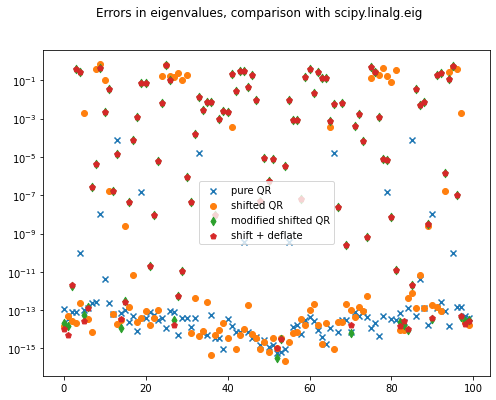

In [292]:
fig, axs = plt.subplots(1, figsize=(8, 6))
#axs.scatter(np.arange(len(scp_eigs)), scp_eigs - , label='eigenvalues from scipy')
axs.scatter(np.arange(len(scp_eigs)), np.abs(scp_eigs - np.sort(np.diag(a_pure))), label='pure QR', marker='x')
axs.scatter(np.arange(len(scp_eigs)), np.abs(scp_eigs - np.sort(np.diag(a_shift))), label='shifted QR', marker='o')
axs.scatter(np.arange(len(scp_eigs)), np.abs(scp_eigs - np.sort(np.diag(a_mod))), label='modified shifted QR', marker='d')
axs.scatter(np.arange(len(scp_eigs)), np.abs(scp_eigs - np.sort(a_defl)), label='shift + deflate', marker='p')
axs.legend()
axs.set_yscale('log')
fig.suptitle("Errors in eigenvalues, comparison with scipy.linalg.eig")

Well, my implementation of deflation results in almost the same errors as the modified shift strategy. 
Can't say that I'm disappointed, it was rather interesting to study all this stuff.

Let's proceed with Wilkinson shift, maybe it will be more ok.

- Try QR with Rayleigh Quotient shift for a simple matrix $A = \begin{bmatrix}
0 & 1 \\
1 & 0
\end{bmatrix}$. Does anything change from iteration to iteration? Does shift affect convergence here? Why?

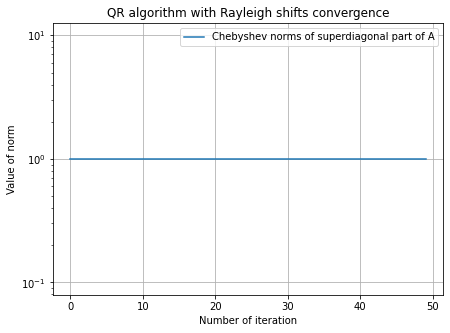

In [287]:
a = np.array([[0, 1], [1, 0]])

band_a, convergence, = qr_algorithm_reileigh(a, 50)

fig, axs = plt.subplots(1, 1, figsize=(7, 5))
axs.plot(np.arange(50), convergence, label="Chebyshev norms of superdiagonal part of A")
axs.set_title("QR algorithm with Rayleigh shifts convergence")
axs.legend()
axs.grid()
axs.set_xlabel("Number of iteration")
axs.set_ylabel("Value of norm")
axs.set_yscale("log")

The problem is that Rayleigh shift doesn't change the matrix at all - subtracting zero from zero makes no difference, so the matrix preserves as it is.

### QR with Wilkinson shift  (15 pts)

To solve the problem that appears in the last example, we can use the Wilkinson shift:

$$\mu = a_m - \frac {sign(\delta) b^2_{m-1}} {(|\delta| + \sqrt{\delta^2 + b^2_{m-1}} )},$$

where $\delta = \frac{(a_{m-1} - a_m)}{2}$. If $\delta = 0$, then instead of $sign(\delta)$ you have to choose $1$ or $-1$ arbitrary.
The numbers $a_m, b_{m-1}, a_{m-1}$ are taken from matrix $B$:

$$
    B = 
    \begin{bmatrix} 
     a_{m-1} & b_{m-1} \\ 
     b_{m-1} & a_m \\ 
    \end{bmatrix},
$$  
which is a lower right bottom submatrix of $A^{(k)}$. Here $k$ is an iteration counter in QR algorithm.

- Compare convergence in the symmetric cases: 
    - distinctive eigenvalues
    - two coincident eigenvalues
    - maximum and minimum eigenvalues with the same absolute value
Choose the dimension $n \sim 100 $ for more representative results.
What do you observe? 

In [293]:
def qr_algorithm_wilkinson(A_init, num_iter):
    """
        QR algorithm with Wilknson shift
        input: matrix A_init of size n x n to find its eigenvalues 
               num_iter number of iterations for algorithm to run 
    """
    convergence = np.empty(num_iter)
    Ak = scipy.linalg.hessenberg(A_init)
    for i in np.arange(num_iter):
        a0 = Ak[-2, -2]
        a1 = Ak[-1, -1]
        b = Ak[-2, -1]
        if a0 == a1:
            sign = np.power((-1), i)
            delta = 0
        else:
            delta = (a0 - a1) / 2
        sign = 1 if delta > 0 else -1
        mu = a1 - sign * b * b / (np.abs(delta) + np.sqrt(delta * delta + b * b))
        
        Ak = Ak - mu * np.eye(Ak.shape[0])
        Q, R = scipy.linalg.qr(Ak)
        Ak = R @ Q + mu * np.eye(Ak.shape[0])
        convergence[i] = scipy.linalg.norm(np.triu(Ak, 1), ord=np.inf)
    return Ak, convergence

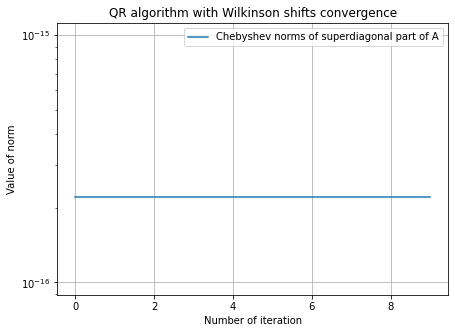

In [294]:
a = np.array([[0, 1], [1, 0]])

band_a, convergence, = qr_algorithm_wilkinson(a, 10)

fig, axs = plt.subplots(1, 1, figsize=(7, 5))
axs.plot(np.arange(10), convergence, label="Chebyshev norms of superdiagonal part of A")
axs.set_title("QR algorithm with Wilkinson shifts convergence")
axs.legend()
axs.grid()
axs.set_xlabel("Number of iteration")
axs.set_ylabel("Value of norm")
axs.set_yscale("log")

We converge instanlty for such a small matrix.

Text(0.5, 1.0, 'Wilkinson shift')

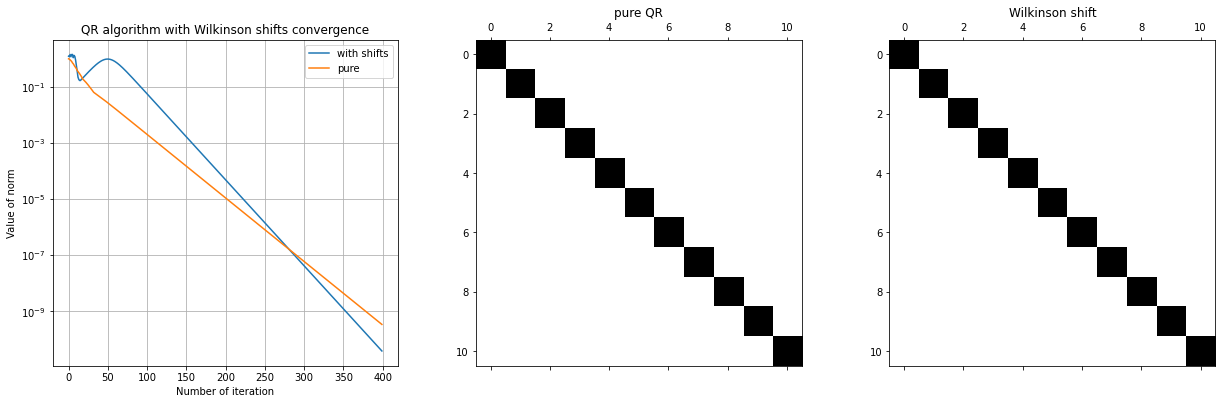

In [295]:
diag_broadcast = [1, 2, 1]
size = 11
band_sym = scipy.sparse.diags(diag_broadcast, [-1, 0, 1], shape=(size, size)).toarray()

num_iter = 400
band_a, convergence = qr_algorithm_wilkinson(band_sym, num_iter)
band_as, conv_as = qr_algorithm(band_sym, num_iter)

fig, axs = plt.subplots(1, 3, figsize=(21, 6))
axs[0].plot(np.arange(num_iter), convergence, label="with shifts")
axs[0].plot(np.arange(num_iter), conv_as, label="pure")
axs[0].set_title("QR algorithm with Wilkinson shifts convergence")
axs[0].legend()
axs[0].grid()
axs[0].set_xlabel("Number of iteration")
axs[0].set_ylabel("Value of norm")
axs[0].set_yscale("log")

axs[1].spy(band_as, 1e-6)
axs[1].set_title("pure QR")
axs[2].spy(band_a, 1e-6)
axs[2].set_title("Wilkinson shift")

Let's take a look at eigenvalues after Wilkinson shift QR (I already learned them well after all this research above)

In [296]:
np.diag(band_a)

array([0.06814835, 0.26794919, 0.58578644, 1.        , 1.48236191,
       2.        , 3.93185165, 3.73205081, 2.51763809, 3.41421356,
       3.        ])

Text(0.5, 1.0, 'Errors in eigenvalues, comparison with scipy.linalg.eig')

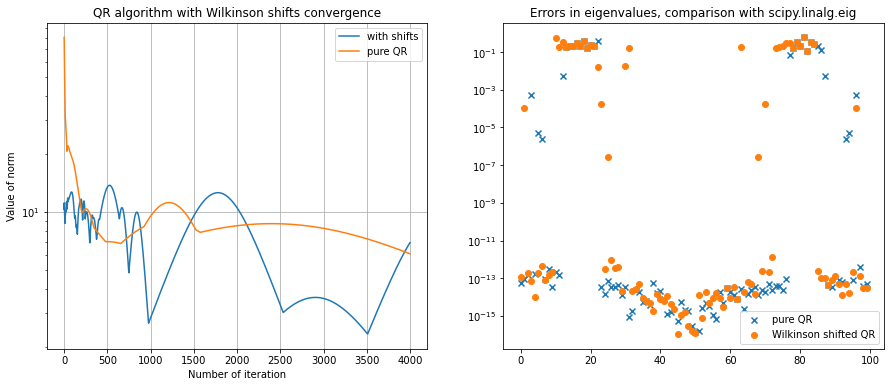

In [297]:
size = 100
A = np.random.randn(size, size)
A = (A + A.T) / 2

scp_eigs = np.sort((scipy.linalg.eig(A)[0].real))

num_iter = 4000
a_shift, conv_shift = qr_algorithm_wilkinson(A, num_iter)
a_pure, conv_pure = qr_algorithm(A, num_iter)

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
axs[0].plot(np.arange(num_iter), conv_shift, label="with shifts")
axs[0].plot(np.arange(num_iter), conv_pure, label="pure QR")
axs[0].set_title("QR algorithm with Wilkinson shifts convergence")
axs[0].legend()
axs[0].grid()
axs[0].set_xlabel("Number of iteration")
axs[0].set_ylabel("Value of norm")
axs[0].set_yscale("log")

axs[1].scatter(np.arange(len(scp_eigs)), np.abs(scp_eigs - np.sort(np.diag(a_pure))), label='pure QR', marker='x')
axs[1].scatter(np.arange(len(scp_eigs)), np.abs(scp_eigs - np.sort(np.diag(a_shift))), label='Wilkinson shifted QR', marker='o')
axs[1].legend()
axs[1].set_yscale('log')
axs[1].set_title("Errors in eigenvalues, comparison with scipy.linalg.eig")

I'm starting to get the strange feeling that eigenvalues of symmetric random normally distributed matrix are symmetric...

In general, there are some large errors, but not as bad as with Rayleigh shift.

Now, let's study:
* distinctive eigenvalues
* two coincident eigenvalues
* maximum and minimum have the same absolute value

In [298]:
from scipy.stats import ortho_group

#these are the exact eigenvalues that we are hoping to obtain from QR algorithm
distinct = np.concatenate((np.arange(1, 11), np.arange(-100, -40), np.arange(20, 40, 2)))
coincident = np.concatenate((np.arange(2, 11), np.arange(-100, -40), np.arange(20, 40, 2), [10]))
max_min = np.concatenate((np.arange(2, 11), np.arange(-100, -40), np.arange(20, 40, 2), [-10]))

#this is a random orthogonal matrix to convert diagonal matrices from above into general form (in some basis)
orth = ortho_group.rvs(len(distinct))

In [299]:
#here we convert the matrices that we're going to study to genral form
#as sampling random orthogonal matrices yields some numerical errors we additionally symmetrise these matrices

first = orth.T @ (orth.T * distinct).T
first = (first + first.T) / 2

second = orth.T @ (orth.T * coincident).T
second = (second + second.T) / 2

third = orth.T @ (orth.T * max_min).T
third = (third + third.T) / 2

Text(0.5, 1.0, 'Errors in eigenvalues, comparison original data, all eigenvalues are distinct')

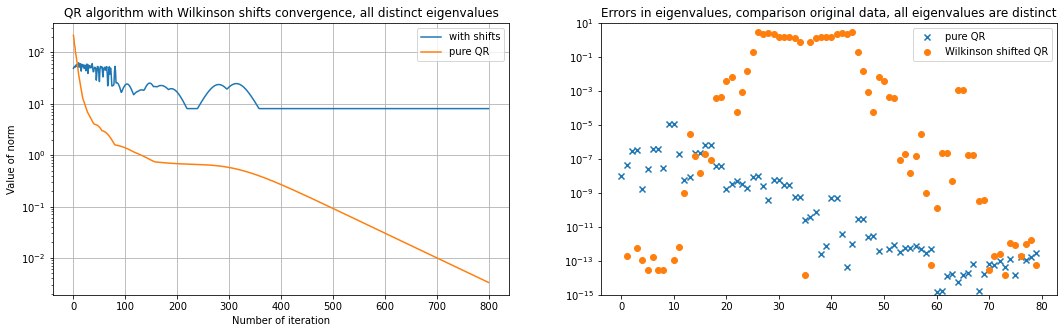

In [310]:
num_iter = 800
first_shift, first_conv_shift = qr_algorithm_wilkinson(first, num_iter)
first_pure, first_conv_pure = qr_algorithm(first, num_iter)

eigs = np.sort(distinct)

fig, axs = plt.subplots(1, 2, figsize=(18, 5))
axs[0].plot(np.arange(num_iter), first_conv_shift, label="with shifts")
axs[0].plot(np.arange(num_iter), first_conv_pure, label="pure QR")
axs[0].set_title("QR algorithm with Wilkinson shifts convergence, all distinct eigenvalues")
axs[0].legend()
axs[0].grid()
axs[0].set_xlabel("Number of iteration")
axs[0].set_ylabel("Value of norm")
axs[0].set_yscale("log")

axs[1].scatter(np.arange(len(eigs)), np.abs(eigs - np.sort(np.diag(first_pure))), label='pure QR', marker='x')
axs[1].scatter(np.arange(len(eigs)), np.abs(eigs - np.sort(np.diag(first_shift))), label='Wilkinson shifted QR', marker='o')
axs[1].legend()
axs[1].set_yscale('log')
axs[1].set_ylim(1e-15, 10)
axs[1].set_title("Errors in eigenvalues, comparison original data, all eigenvalues are distinct")

Text(0.5, 1.0, 'Errors in eigenvalues, comparison original data, two coincident eigenvalues')

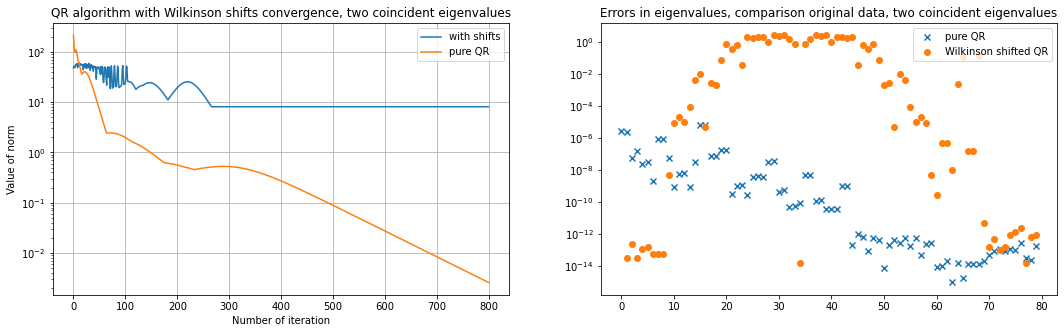

In [308]:
num_iter = 800
second_shift, second_conv_shift = qr_algorithm_wilkinson(second, num_iter)
second_pure, second_conv_pure = qr_algorithm(second, num_iter)

eigs = np.sort(coincident)

fig, axs = plt.subplots(1, 2, figsize=(18, 5))
axs[0].plot(np.arange(num_iter), second_conv_shift, label="with shifts")
axs[0].plot(np.arange(num_iter), second_conv_pure, label="pure QR")
axs[0].set_title("QR algorithm with Wilkinson shifts convergence, two coincident eigenvalues")
axs[0].legend()
axs[0].grid()
axs[0].set_xlabel("Number of iteration")
axs[0].set_ylabel("Value of norm")
axs[0].set_yscale("log")

axs[1].scatter(np.arange(len(eigs)), np.abs(eigs - np.sort(np.diag(second_pure))), label='pure QR', marker='x')
axs[1].scatter(np.arange(len(eigs)), np.abs(eigs - np.sort(np.diag(second_shift))), label='Wilkinson shifted QR', marker='o')
axs[1].legend()
axs[1].set_yscale('log')
axs[1].set_title("Errors in eigenvalues, comparison original data, two coincident eigenvalues")

Text(0.5, 1.0, 'Errors in eigenvalues, comparison original data, two opposite eigenvalues')

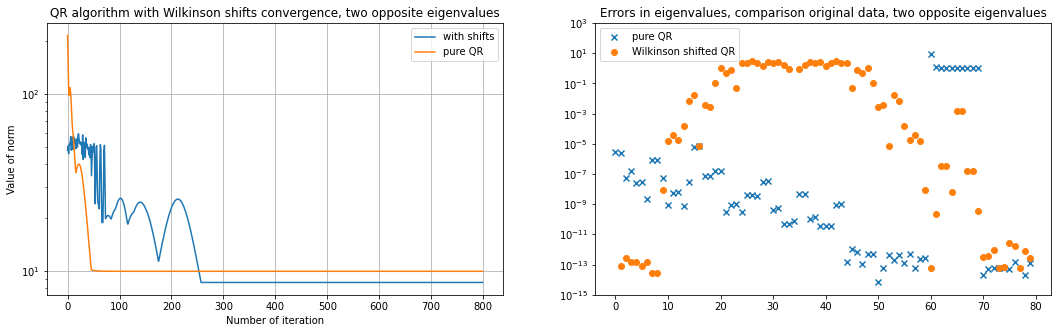

In [307]:
num_iter = 800
third_shift, third_conv_shift = qr_algorithm_wilkinson(third, num_iter)
third_pure, third_conv_pure = qr_algorithm(third, num_iter)

eigs = np.sort(max_min)

fig, axs = plt.subplots(1, 2, figsize=(18, 5))
axs[0].plot(np.arange(num_iter), third_conv_shift, label="with shifts")
axs[0].plot(np.arange(num_iter), third_conv_pure, label="pure QR")
axs[0].set_title("QR algorithm with Wilkinson shifts convergence, two opposite eigenvalues")
axs[0].legend()
axs[0].grid()
axs[0].set_xlabel("Number of iteration")
axs[0].set_ylabel("Value of norm")
axs[0].set_yscale("log")

axs[1].scatter(np.arange(len(eigs)), np.abs(eigs - np.sort(np.diag(third_pure))), label='pure QR', marker='x')
axs[1].scatter(np.arange(len(eigs)), np.abs(eigs - np.sort(np.diag(third_shift))), label='Wilkinson shifted QR', marker='o')
axs[1].legend()
axs[1].set_yscale('log')
axs[1].set_ylim(1e-15, 1e3)
axs[1].set_title("Errors in eigenvalues, comparison original data, two opposite eigenvalues")

Well, usual, "pure" QR algorithm works quite well (in terms of eigenvalue restoration from the matrix), but in the latter case (with two eigenvalues of the opposite sign) it struggles to diagonolize matrix properly.

Wilkinson shift algorithm performs much worse both in terms of eigenvalues accuracy and diagonalization of the matrix. 

I assume for diagonalization we absolutely have to use some kind of deflation and/or manual assignment to zero of close to zero entrie of the matrix (then we will obtain diagonalized version of symmetric matrix much faster, then with pure QR - check allthe plots in Rayleigh quontient shift study). 

HOWEVER, from the tests with Rayleigh shifts we can see that the problem with eigenvalues accuracy still preserves for shifts and deflation. 

## Problem 4. (Movie Recommender system) 15 pts

Imagine the world without NLA where you have free evenings and you can watch movies!  
But it is always hard to choose a movie to watch. 
In this problem we suggest you to build your own movie recommender system based on SVD decomposition, so you can combine two perfect things: Numerical Linear Algebra and cinematography!

In order to build recommender system you need data. 
Here you are https://grouplens.org/datasets/movielens/1m/

Usually all recommender systems may be devided into two groups

#### Collaborative filtering. 

This approach is based on user-item interaction.
It has one important assumption: user who has liked an item in the past will also likes the same in the future. Suppose the user A likes the films about vampires. 
He is Twilight saga fan and he has watched the film "What we do in the shadows" and liked it or unliked it, in other words he evaluated it somehow. And suppose another user B, who has the similair behavior to the first user (he is also Twilight saga fan). And the chance, that he will estimate "What we do in the shadows" in the same way that user A did, is huge. So, the purpose of the collaborative filtering is to predict a user's behavior based on behavior of the simular users.

#### Content based filtering.

Collaborative filtering has some essential flaws. The main one is called "cold start". "Cold start" happens when the new user comes and he has not react anyhow to the items. So we do not know his past behavior and we do not know what to advise. Here content based filtering helps. Often resources gather some extra info about users and items before a user comes down to utilising the resource. So, for example we would know that user likes horror movies before he watched anything on the resource.


- In this task you will implement Collaborative filtering based on SVD (we will use the function from the proper package and check if the result recommender system advices the similar movies)

1) (1 pts)  Explore the data. Construct the interaction matrix $M$ of size $m \times n$ which contains the information of how a certain user rated a certain film. 

2) (5 pts)  Compute SVD of this matrix. Remeber that matrix $M$ is sparse (one user can hardly watch all the movies) so the good choice would be to use method from ```scipy.sparse.linalg``` package

$$ M = USV^{\top}, $$

where $U$ is a $m \times r $ orthogonal matrix with left singular vectors, which represents the relationship between users and latent factors, $S$ is a $r \times r $ diagonal matrix, which describes the strength of each latent factor and $V^\top$ is a $r \times n$ matrix with right singular vectors, which represent the embeddings of  items (movies in our case) in latent space.
Describe any simple heuristic to choose appropriate value for $r$ and explain why do you expect that it will work.


In [153]:
# Importing Libraries
import numpy as np
import pandas as pd

import scipy as sp
import scipy.sparse as spsp
import scipy.sparse.linalg

# Read the dataset
users = pd.read_csv("ml-1m/users.dat", sep="::", header=None, engine='python')
ratings = pd.read_csv("ml-1m/ratings.dat", sep="::", header=None, names=['UserId', 'MovieId', 'Rating', 'Timestamp'], engine='python')
movies = pd.read_csv("ml-1m/movies.dat", sep="::", header=None, names=['MovieId', 'Title', 'Genre'], engine='python')

In [154]:
movies.sample(5)

,MovieId,Title,Genre
471,475,In the Name of the Father (1993),Drama
1289,1309,Parallel Sons (1995),Drama|Romance
2002,2071,And the Band Played On (1993),Drama
2079,2148,House (1986),Comedy|Horror
1248,1268,Pump Up the Volume (1990),Drama


In [155]:
ratings.head()

,UserId,MovieId,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [159]:
dat = ratings.join(movies.reset_index().set_index('MovieId'), on='MovieId')

dat.head()

,UserId,MovieId,Rating,Timestamp,index,Title,Genre
0,1,1193,5,978300760,1176,One Flew Over the Cuckoo's Nest (1975),Drama
1,1,661,3,978302109,655,James and the Giant Peach (1996),Animation|Children's|Musical
2,1,914,3,978301968,902,My Fair Lady (1964),Musical|Romance
3,1,3408,4,978300275,3339,Erin Brockovich (2000),Drama
4,1,2355,5,978824291,2286,"Bug's Life, A (1998)",Animation|Children's|Comedy


In [168]:
# Create the interaction matrix
interaction = spsp.csr_matrix((dat['Rating'], (dat['UserId'], dat['index']))).asfptype()

In the readme file it's stated that there are following genre partition in the dataset:
* Action
* Adventure
* Animation
* Children's
* Comedy
* Crime
* Documentary
* Drama
* Fantasy
* Film-Noir
* Horror
* Musical
* Mystery
* Romance
* Sci-Fi
* Thriller
* War
* Western

So 18 genres in total. Let's use 18 as dimensionality of the latent space. We assume that there is a latent space of genres, so each film has its embedding in this space based on what genres it can be described by. 

In this case users have some preferencies in genres as well, so whether they react on the film or not depends on its genre - if user likes dramas (like The Falcon and the Snowman) and thrillers (like Red Rock West), then this user will probably like Cutter's Way (described as drama\thriller)


In [169]:
# Compute Singular Value Decomposition of interaction matrix. You can use built-in functions
genres = 18
U, S, V = scipy.sparse.linalg.svds(interaction, k=genres)

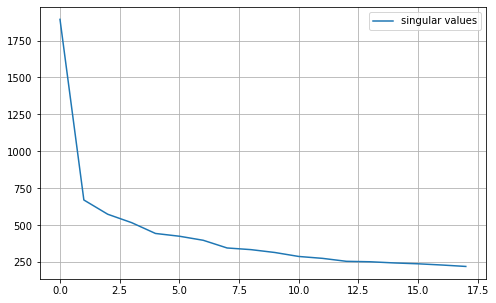

In [170]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 1, figsize=(8,5))
axs.plot(np.arange(genres), np.sort(S)[::-1], label="singular values")
axs.grid()
#axs.set_yscale('log')
axs.legend()

3) (2 pts) In order to get weighted item-latent factors, we can multiply $S$ and $V^{T}$. Please, remember that $S$ is diagonal and multiply them efficiently.

In [171]:
svt = S * V.T

In [172]:
svt.shape

(3883, 18)

Now we have vectors that represent our item space. In other words we have $N$ movies and $N$ vectors which describe each movie, a.k.a. embeddings. 
In order to know if two movies are similar or not we need just to check if the corresponding vectors are similair or not. How we can do this?

4) (2 pts)  Implement the cosine metric. If the cosine metric between two vectors equals to $1$ both vectors are collinear, if $0$ vectors are orthogonal, as a result corresponding movies are completely different.

$$
cosine(u,v) = \frac{u^{\top}v}{\|u\|_2\|v\|_2}
$$

In [202]:
def cosine(u, v):
    return u @ v /(np.linalg.norm(u) * np.linalg.norm(v))

5) (5 pts) Check your result. Implement the fuction, which finds and prints $k$ similar movies to the one you have chosen

In [206]:
def get_movie_name(mov_ind, data):
    mask = data['index'] == mov_ind
    return np.unique(data[mask].iloc[:, 5])[0]

def get_movie_genre(mov_ind, data):
    mask = data['index'] == mov_ind
    return np.unique(data[mask].iloc[:, 6])[0]

def get_movie_vec(mov_ind, vecs):
    return vecs[mov_ind]

def get_similar_movies(mov_ind, vecs, data, num_movies=10):
    names = []
    genres = []
    cosvals = []
    mov_vec = get_movie_vec(mov_ind, vecs)
    
    cosines = np.empty(vecs.shape[0])
    
    for i, item in enumerate(vecs):
        cosines[i] = cosine(mov_vec, item)
        
    prop_inds = np.argsort(cosines)[-num_movies+1:-1]
    
    prop_inds = prop_inds[::-1]
    for item in prop_inds:
        names.append(get_movie_name(item, data))
        genres.append(get_movie_genre(item, data))
        cosvals.append(cosines[item])
        
    return names, genres, cosvals

In [208]:
movid = 257
names, genres, cosvals = get_similar_movies(movid, svt, dat, num_movies=15)
print("You liked \"{}\"\nYou may also like:".format(get_movie_name(movid, dat)))
for movie, genre, val in zip(names, genres, cosvals):
    print("\"{}\", {}, {:.2f}".format(movie, genre, val))

You liked "Star Wars: Episode IV - A New Hope (1977)"
You may also like:
"Star Wars: Episode V - The Empire Strikes Back (1980)", Action|Adventure|Drama|Sci-Fi|War, 0.99
"Star Wars: Episode VI - Return of the Jedi (1983)", Action|Adventure|Romance|Sci-Fi|War, 0.98
"Raiders of the Lost Ark (1981)", Action|Adventure, 0.95
"Terminator, The (1984)", Action|Sci-Fi|Thriller, 0.95
"Alien (1979)", Action|Horror|Sci-Fi|Thriller, 0.93
"Aliens (1986)", Action|Sci-Fi|Thriller|War, 0.93
"E.T. the Extra-Terrestrial (1982)", Children's|Drama|Fantasy|Sci-Fi, 0.92
"Terminator 2: Judgment Day (1991)", Action|Sci-Fi|Thriller, 0.91
"Matrix, The (1999)", Action|Sci-Fi|Thriller, 0.91
"Back to the Future (1985)", Comedy|Sci-Fi, 0.90
"Star Wars: Episode I - The Phantom Menace (1999)", Action|Adventure|Fantasy|Sci-Fi, 0.89
"Jurassic Park (1993)", Action|Adventure|Sci-Fi, 0.89
"Indiana Jones and the Last Crusade (1989)", Action|Adventure, 0.88


Enjoy watching the recommended movies!


Recommendations are quite good. I suppose it's time to rewatch the fifth episode of Star Wars. 

Btw, The Matrix is going to be shown in theatres before the forth film comes out...